# Importación de librerías

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import re
import h5py
from scipy import signal
from scipy.signal import filtfilt
import pandas as pd

## Leyendo el archivos

In [17]:
# Parámetros del BITalino EEG
fs = 1000                # Frecuencia de muestreo (Hz)
GAIN = 40000             # Ganancia del canal EEG del BITalino
VCC = 3.3                # Voltaje de referencia ADC
ADC_RES = 1024.0         # Resolución del ADC (10 bits)
OFFSET = 512             # Valor medio del ADC BITalino

def analizar_eeg(ruta, base, canal, inicio, fin):
    with h5py.File(ruta, "r") as f:
        data = f[f"{base}/{canal}"][:].squeeze()

    # --- Conversión a microvoltios (µV) ---
    centered = data.astype(np.float32) - OFFSET              # Quitar offset ADC
    volt = centered * (VCC / ADC_RES)                        # Convertir a voltios
    eeg_volt = volt / GAIN                                   # Dividir por ganancia
    microvolt = eeg_volt * 1e6                               # Pasar a microvoltios
    microvolt -= np.mean(microvolt)                          # Quitar DC residual

    # --- Eje temporal completo ---
    t = np.arange(len(microvolt)) / fs

    # --- Segmento de interés ---
    idx0, idx1 = int(inicio * fs), min(int(fin * fs), len(microvolt))
    seg = microvolt[idx0:idx1]

    # Eje temporal del segmento (reiniciado desde 0)
    t_seg = np.arange(0, len(seg)) / fs

    return seg, t_seg


In [18]:
# Uso
y_1, t_1 = analizar_eeg("ojos_abiertos.h5", "0C:43:14:1C:2A:02/raw", "channel_4", 5, 70)
y_2, t_2 = analizar_eeg("ojos_cerrados.h5", "0C:43:14:1C:2A:02/raw", "channel_4", 0, 50)
y_3, t_3 = analizar_eeg("tarea_cognitiva.h5", "0C:43:14:1C:2A:02/raw", "channel_4", 10, 55)
y_4, t_4 = analizar_eeg("parpadeo.h5", "0C:43:14:1C:2A:02/raw", "channel_4", 30, 90)
y_5, t_5 = analizar_eeg("masticar.h5", "0C:43:14:1C:2A:02/raw", "channel_4", 30, 95)
y_6, t_6 = analizar_eeg("musica_clasica.h5", "0C:43:14:1C:2A:02/raw", "channel_4", 35, 95)
y_7, t_7 = analizar_eeg("ondas_alfa.h5", "0C:43:14:1C:2A:02/raw", "channel_4", 35, 95)
y_8, t_8 = analizar_eeg("musica_metal.h5", "0C:43:14:1C:2A:02/raw", "channel_4", 35, 95)

## A) Análisis para señal: Ojos abiertos

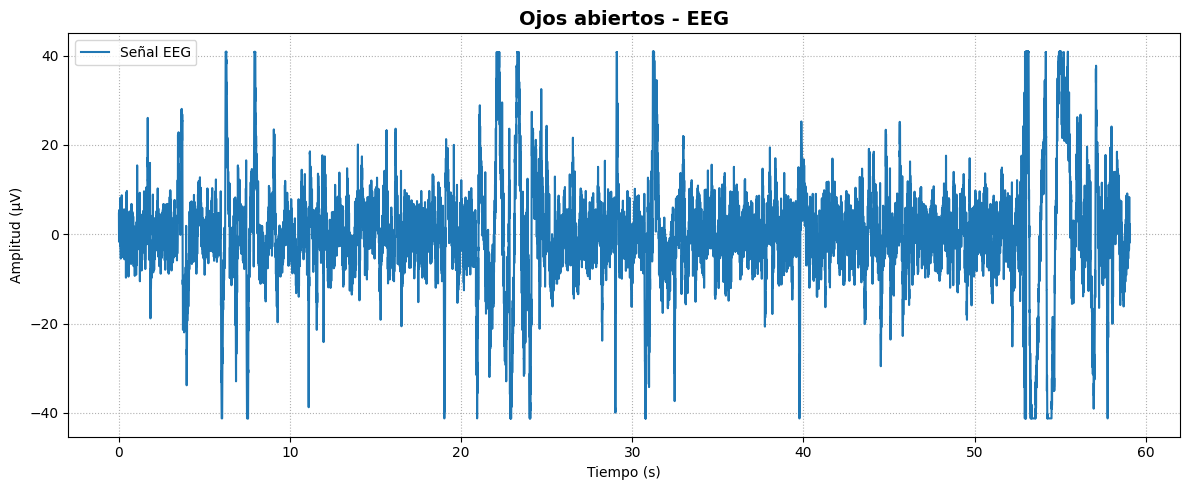

In [19]:
# --- Gráfico de la señal EEG ---
plt.figure(figsize=(12, 5))
plt.plot(t_1, y_1, label="Señal EEG")
titulo = "Ojos abiertos - EEG"
plt.title(titulo, fontsize=14, fontweight='bold', loc='center')  # centrado correctamente
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud (µV)")
plt.grid(linestyle=":")
plt.legend()
plt.tight_layout()
plt.show()


## DFT

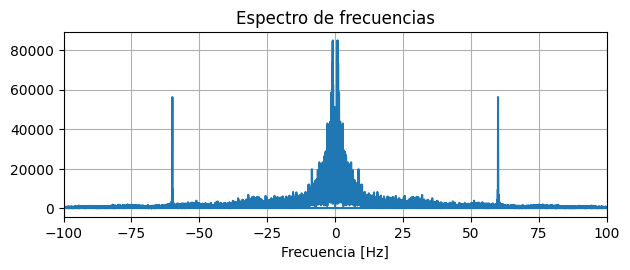

In [20]:
# Calcular la DFT
X = np.fft.fft(y_1)

# Calcular las frecuencias correspondientes
frequencies = np.fft.fftfreq(len(y_1), 1/fs)

plt.subplot(2, 1, 2)
plt.plot(frequencies, np.abs(X))
plt.title('Espectro de frecuencias')
plt.xlabel('Frecuencia [Hz]')
plt.grid()

# Establecer límites en el eje x
plt.xlim([-100, 100])

plt.tight_layout()
plt.show()

## STFT

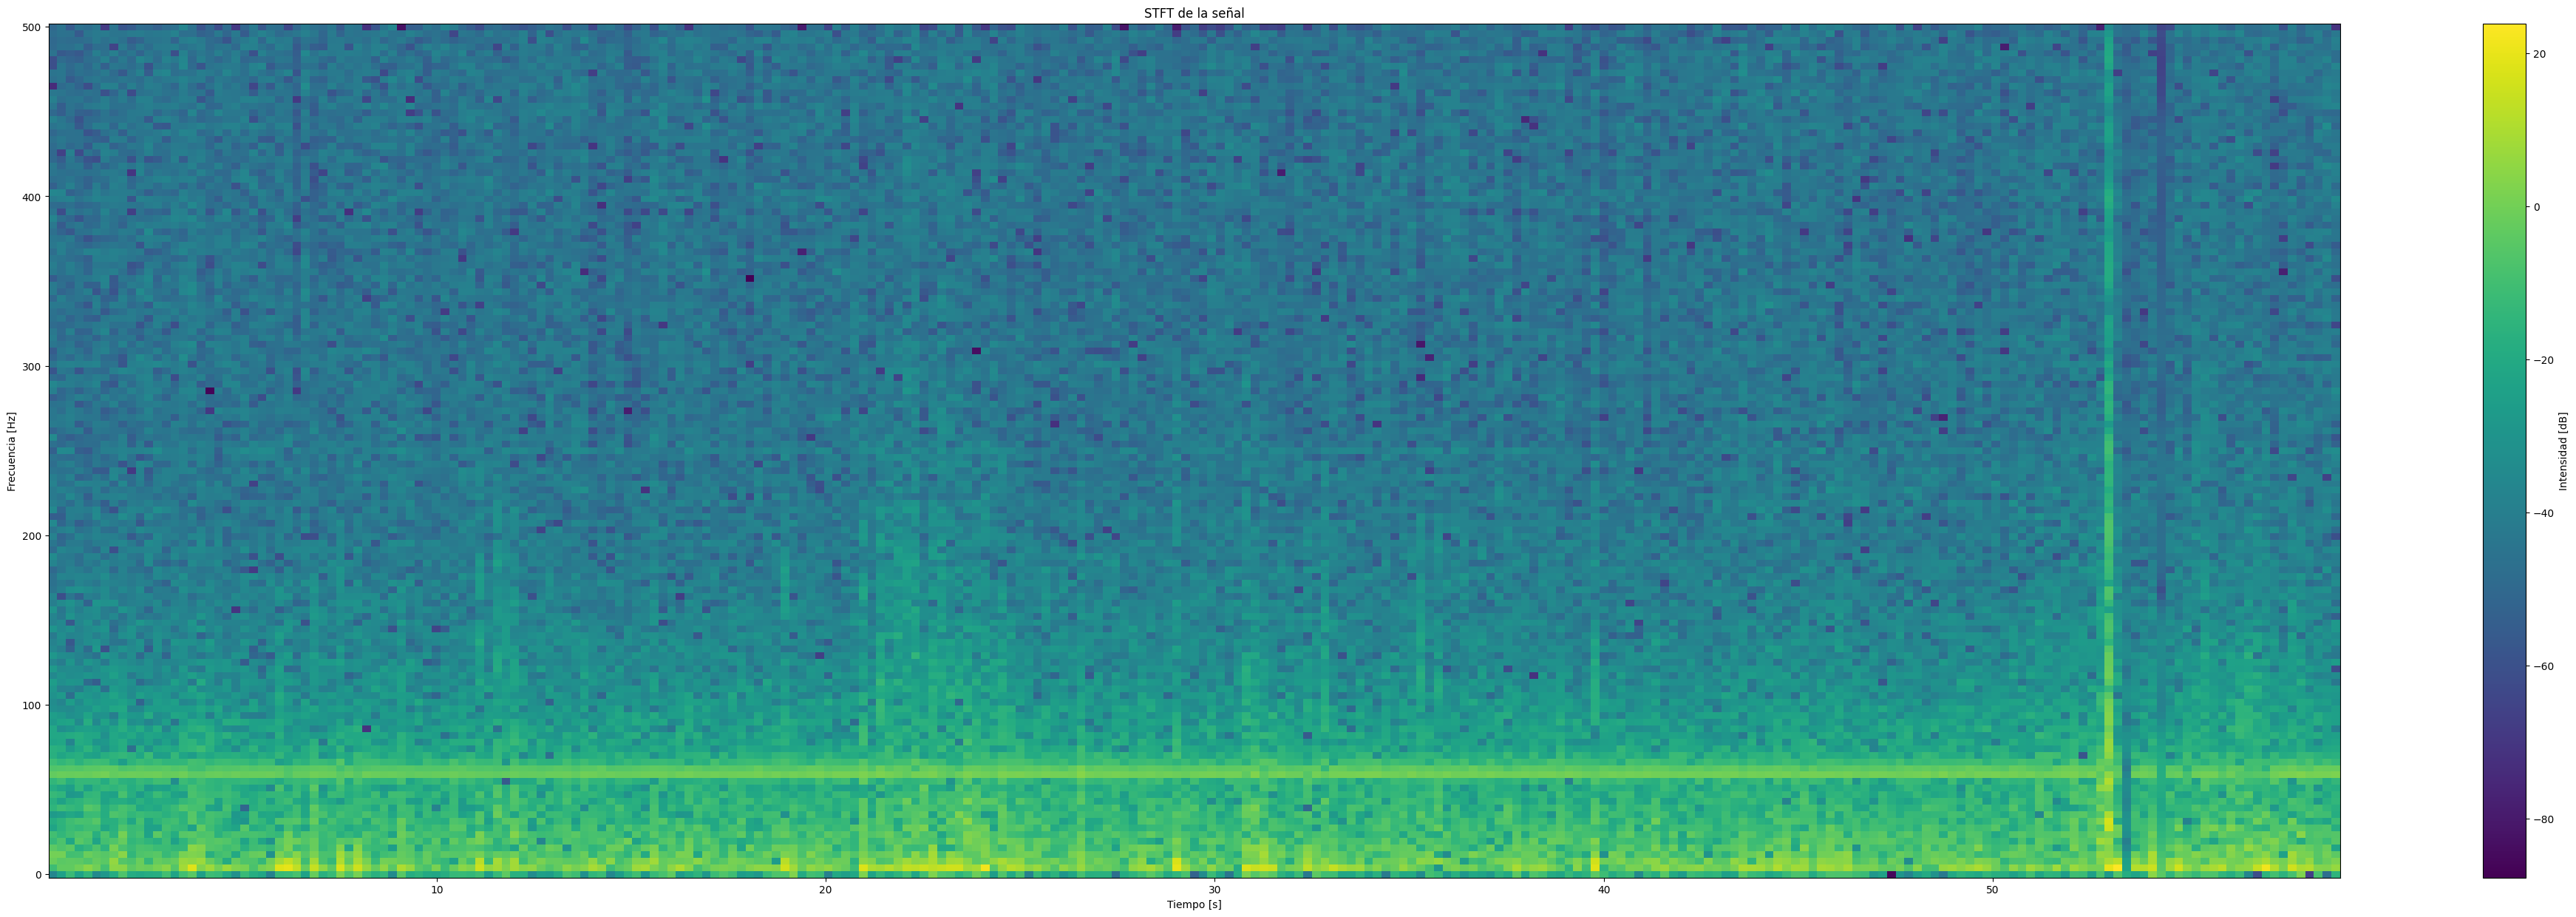

In [21]:
from scipy.signal import spectrogram
import matplotlib.pyplot as plt

# Calcular la STFT
f, t, Sxx = spectrogram(y_1, fs)
plt.figure(figsize=(50, 15))

# Visualizar el espectrograma
plt.pcolormesh(t, f, 10 * np.log10(Sxx))  # Usamos escala logarítmica para mejor visualización
plt.title('STFT de la señal')
plt.ylabel('Frecuencia [Hz]')
plt.xlabel('Tiempo [s]')
plt.colorbar(label='Intensidad [dB]')
plt.show()


# Transformada de Wavelet Continua (CWT)

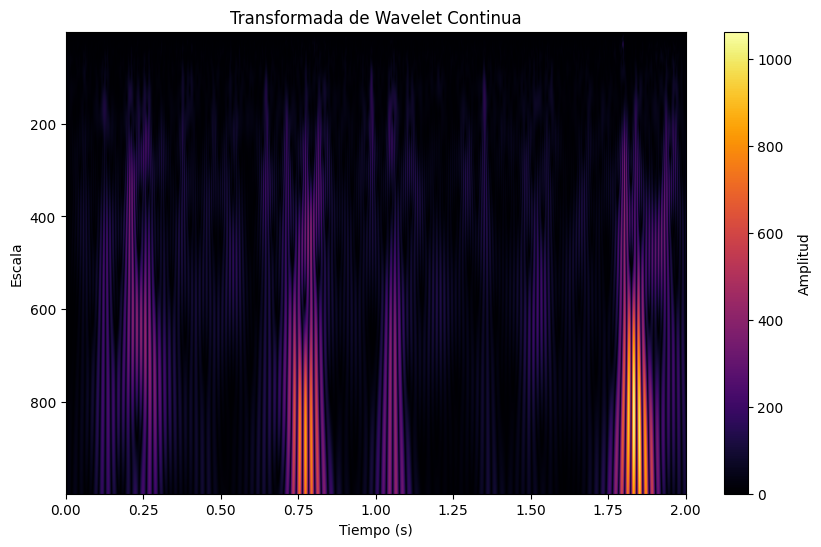

¿coinciden frecuencias?  True


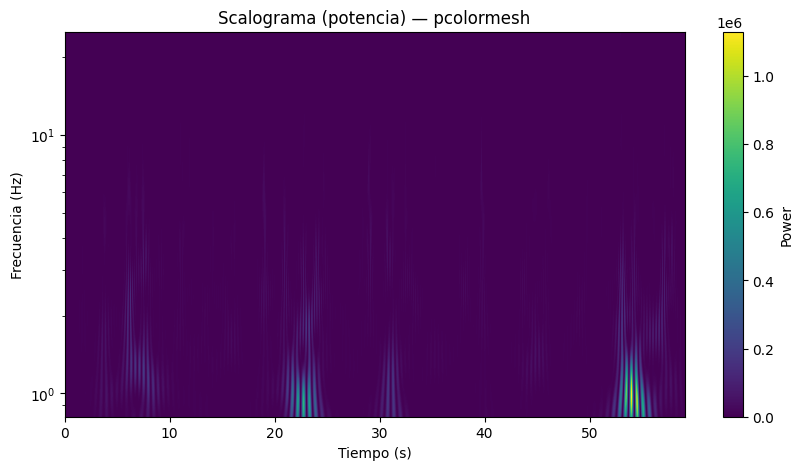

In [22]:
import pywt

# Definir la escala y la frecuencia central de la wavelet de Morlet
escala = np.arange(1, 1000)

# Realizar la transformada de wavelet continua
coeficientes, frecuencias = pywt.cwt(y_1, escala, 'morl',sampling_period=1/1000)

# Graficar los coeficientes de la transformada de wavelet
plt.figure(figsize=(10, 6))
plt.imshow(np.abs(coeficientes), extent=[0, 2, escala[-1], escala[0]], aspect='auto', cmap='inferno')
plt.colorbar(label='Amplitud')
plt.title('Transformada de Wavelet Continua')
plt.xlabel('Tiempo (s)')
plt.ylabel('Escala')
plt.show()


# verificación (opcional): calcular frecuencias con scale2frequency
freqs_check = pywt.scale2frequency('morl', escala) * fs
print("¿coinciden frecuencias? ", np.allclose(frecuencias, freqs_check))

# potencia (o magnitud), y normalización si quieres comparar escalas
power = np.abs(coeficientes)**2
# normalización común para comparar amplitudes entre escalas:
power_norm = power / np.sqrt(escala)[:, None]

# 1) Usando pcolormesh
plt.figure(figsize=(10,5))
plt.pcolormesh(t_1, frecuencias, power, shading='auto');
plt.ylabel('Frecuencia (Hz)')
plt.xlabel('Tiempo (s)')
plt.yscale('log')
plt.title('Scalograma (potencia) — pcolormesh')
plt.colorbar(label='Power')
plt.ylim(frecuencias.min(),25)
plt.show()



# Transformada de Wavelet Discreta (DWT)

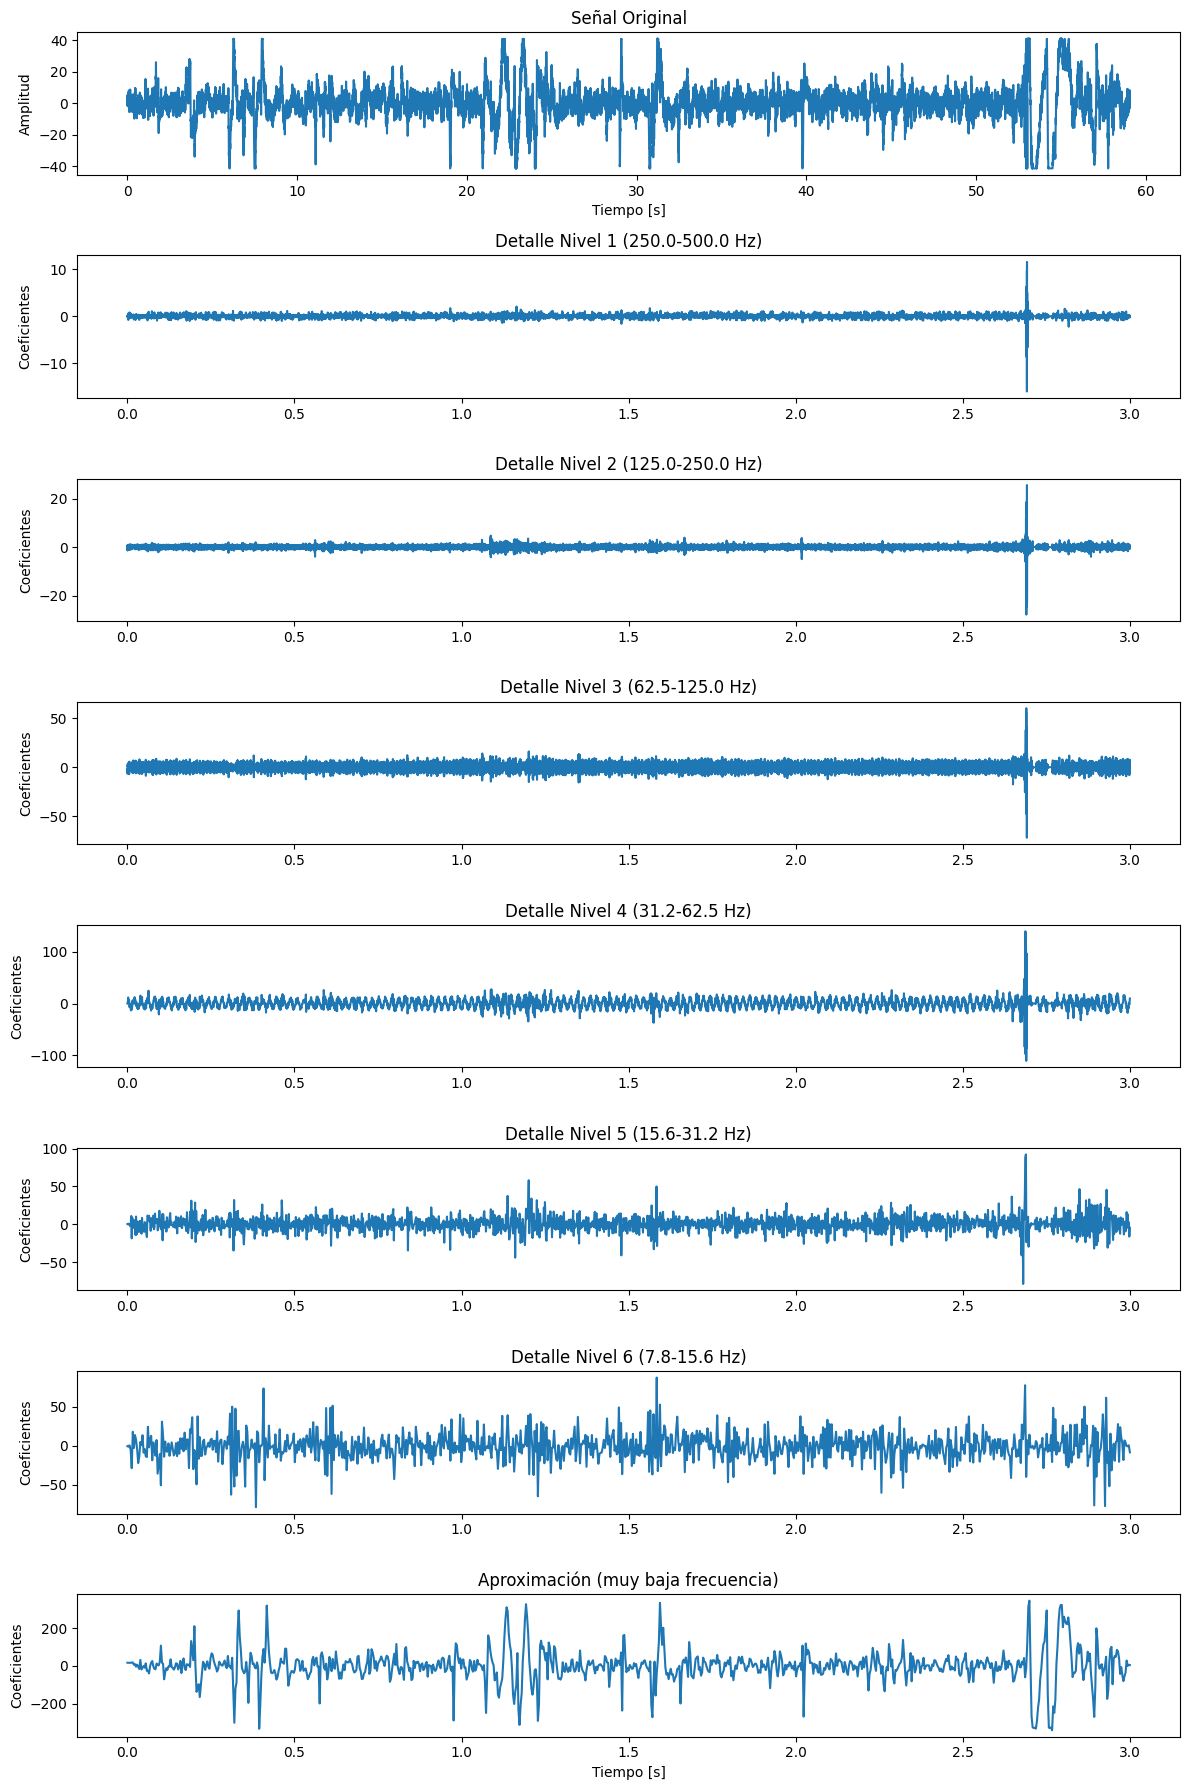

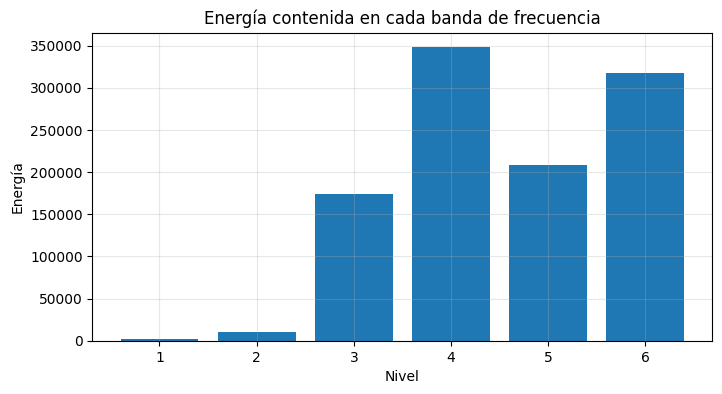

Nivel 1: 250.00 - 500.00 Hz | Energía = 2044.89
Nivel 2: 125.00 - 250.00 Hz | Energía = 10736.91
Nivel 3: 62.50 - 125.00 Hz | Energía = 174493.00
Nivel 4: 31.25 - 62.50 Hz | Energía = 348031.19
Nivel 5: 15.62 - 31.25 Hz | Energía = 208614.98
Nivel 6: 7.81 - 15.62 Hz | Energía = 317259.91


In [23]:
import numpy as np
import matplotlib.pyplot as plt
import pywt

# ======================================
# PARTE 1: DWT
# ======================================
wavelet = 'db4'
niveles = 6
coeficientes = pywt.wavedec(y_1, wavelet, level=niveles)

# ======================================
# PARTE 2: Análisis de energía y bandas
# ======================================
# wavedec devuelve: [cA_n, cD_n, cD_{n-1}, ..., cD_1]
# Queremos graficar los detalles del 1 al n (altas → bajas)
detalles = coeficientes[1:][::-1]  # invertimos el orden

energias = [np.sum(np.square(c)) for c in detalles]

# Bandas de frecuencia aproximadas para cada nivel
bandas = [(fs / (2 ** (i + 1)), fs / (2 ** i)) for i in range(1, niveles + 1)]

# ======================================
# PARTE 3: Gráficas
# ======================================
plt.figure(figsize=(12, 18))
plt.subplot(niveles + 2, 1, 1)
plt.plot(t_1, y_1)
plt.title('Señal Original')
plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud')

# Graficar los niveles 1 → n (altas → bajas)
for i, c in enumerate(detalles, start=1):
    t_c = np.linspace(0, 3, len(c))  # eje temporal aproximado
    plt.subplot(niveles + 2, 1, i + 1)
    plt.plot(t_c, c)
    plt.title(f'Detalle Nivel {i} ({bandas[i-1][0]:.1f}-{bandas[i-1][1]:.1f} Hz)')
    plt.ylabel('Coeficientes')

# Aproximación final (muy baja frecuencia)
t_a = np.linspace(0, 3, len(coeficientes[0]))
plt.subplot(niveles + 2, 1, niveles + 2)
plt.plot(t_a, coeficientes[0])
plt.title('Aproximación (muy baja frecuencia)')
plt.xlabel('Tiempo [s]')
plt.ylabel('Coeficientes')

plt.tight_layout()
plt.show()

# ======================================
# PARTE 4: Energía por nivel
# ======================================
plt.figure(figsize=(8, 4))
niveles_list = np.arange(1, niveles + 1)
plt.bar(niveles_list, energias)
plt.xlabel('Nivel')
plt.ylabel('Energía')
plt.title('Energía contenida en cada banda de frecuencia')
plt.xticks(niveles_list)
plt.grid(True, alpha=0.3)
plt.show()

# Mostrar tabla resumen
for i, (f_low, f_high) in enumerate(bandas):
    print(f"Nivel {i+1}: {f_low:.2f} - {f_high:.2f} Hz | Energía = {energias[i]:.2f}")



## Filtrar señal con Wavelet (db4)

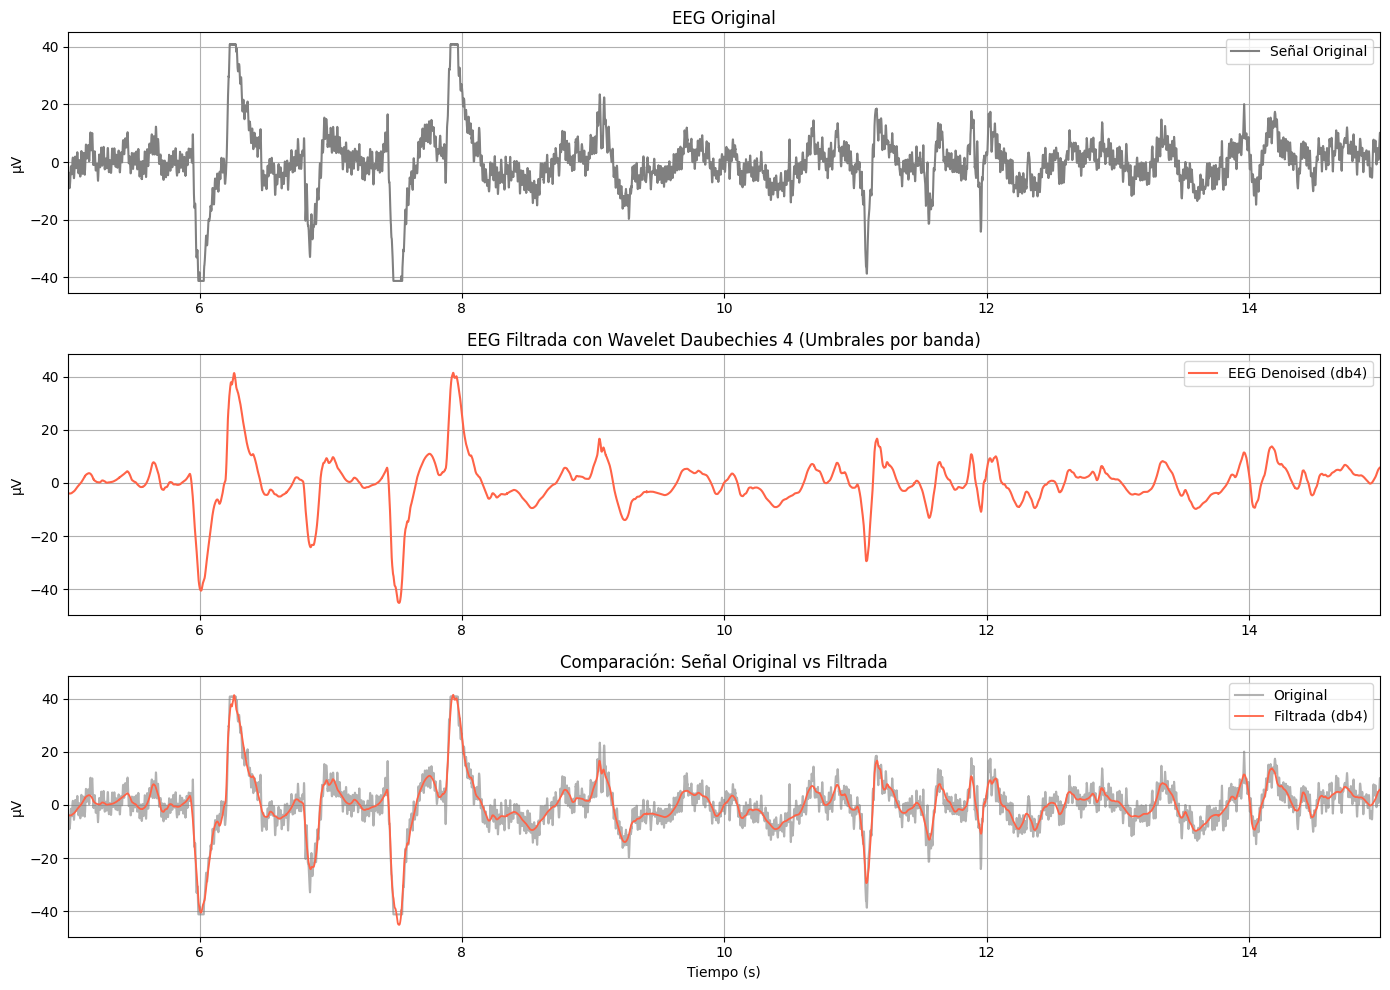

In [24]:
# --- Descomposición wavelet ---
wavelet = 'db4'
nivel = 6
coeffs = pywt.wavedec(y_1, wavelet, level=nivel)

# --- Parámetros generales ---
fs = 1000  # Hz (frecuencia de muestreo)

# --- Aplicar umbrales manuales según banda EEG ---
coeffs_umbral = []
for i, c in enumerate(coeffs):
    if i == 0:
        # A6 → componente más lenta (delta + theta)
        # No se filtra agresivamente
        coeffs_umbral.append(c)
    else:
        # Estimación del ruido y umbral tipo VisuShrink
        sigma = np.median(np.abs(c)) / 0.6745
        T = sigma * np.sqrt(2 * np.log(len(c)))

        # Nota: i=1 → D6, i=6 → D1 (orden inverso en PyWavelets)
        if i == 1:  # D6 (alfa, 8–16 Hz)
            T *= 0.3  # conservar más señal
        elif i == 2:  # D5 (beta, 16–32 Hz)
            T *= 0.6
        elif i == 3:  # D4 (gamma baja)
            T *= 0.8
        elif i == 4:  # D3 (gamma alta)
            T *= 1
        elif i >= 5:  # D2-D1 (ruido)
            T *= 1.5  # filtrar más agresivo

        # Aplicar umbral suave
        coeffs_umbral.append(pywt.threshold(c, T, mode='soft'))

# --- Reconstrucción denoised ---
senal_denoised = pywt.waverec(coeffs_umbral, wavelet)
senal_denoised = senal_denoised[:len(y_1)]  # ajustar tamaño por si cambia

# --- Asignar bandas EEG aproximadas ---
bandas = ['A6 (δ+θ 0–8 Hz)', 'D6 (α 8–16 Hz)', 'D5 (β 16–32 Hz)',
          'D4 (γ baja 32–64 Hz)', 'D3 (γ alta 64–128 Hz)',
          'D2 (ruido muscular 128–256 Hz)', 'D1 (ruido >256 Hz)']

# --- Gráficas comparativas ---
plt.figure(figsize=(14, 10))

# Señal original
plt.subplot(3, 1, 1)
plt.plot(t_1, y_1, color='gray', label='Señal Original')
plt.title('EEG Original')
plt.xlim(5, 15)
plt.ylabel('µV')
plt.grid(True)
plt.legend()

# Señal denoised
plt.subplot(3, 1, 2)
plt.plot(t_1, senal_denoised, color='tomato', label='EEG Denoised (db4)')
plt.title('EEG Filtrada con Wavelet Daubechies 4 (Umbrales por banda)')
plt.xlim(5, 15)
plt.ylabel('µV')
plt.grid(True)
plt.legend()

# Comparación directa
plt.subplot(3, 1, 3)
plt.plot(t_1, y_1, color='gray', alpha=0.6, label='Original')
plt.plot(t_1, senal_denoised, color='tomato', linewidth=1.3, label='Filtrada (db4)')
plt.title('Comparación: Señal Original vs Filtrada')
plt.xlim(5, 15)
plt.xlabel('Tiempo (s)')
plt.ylabel('µV')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


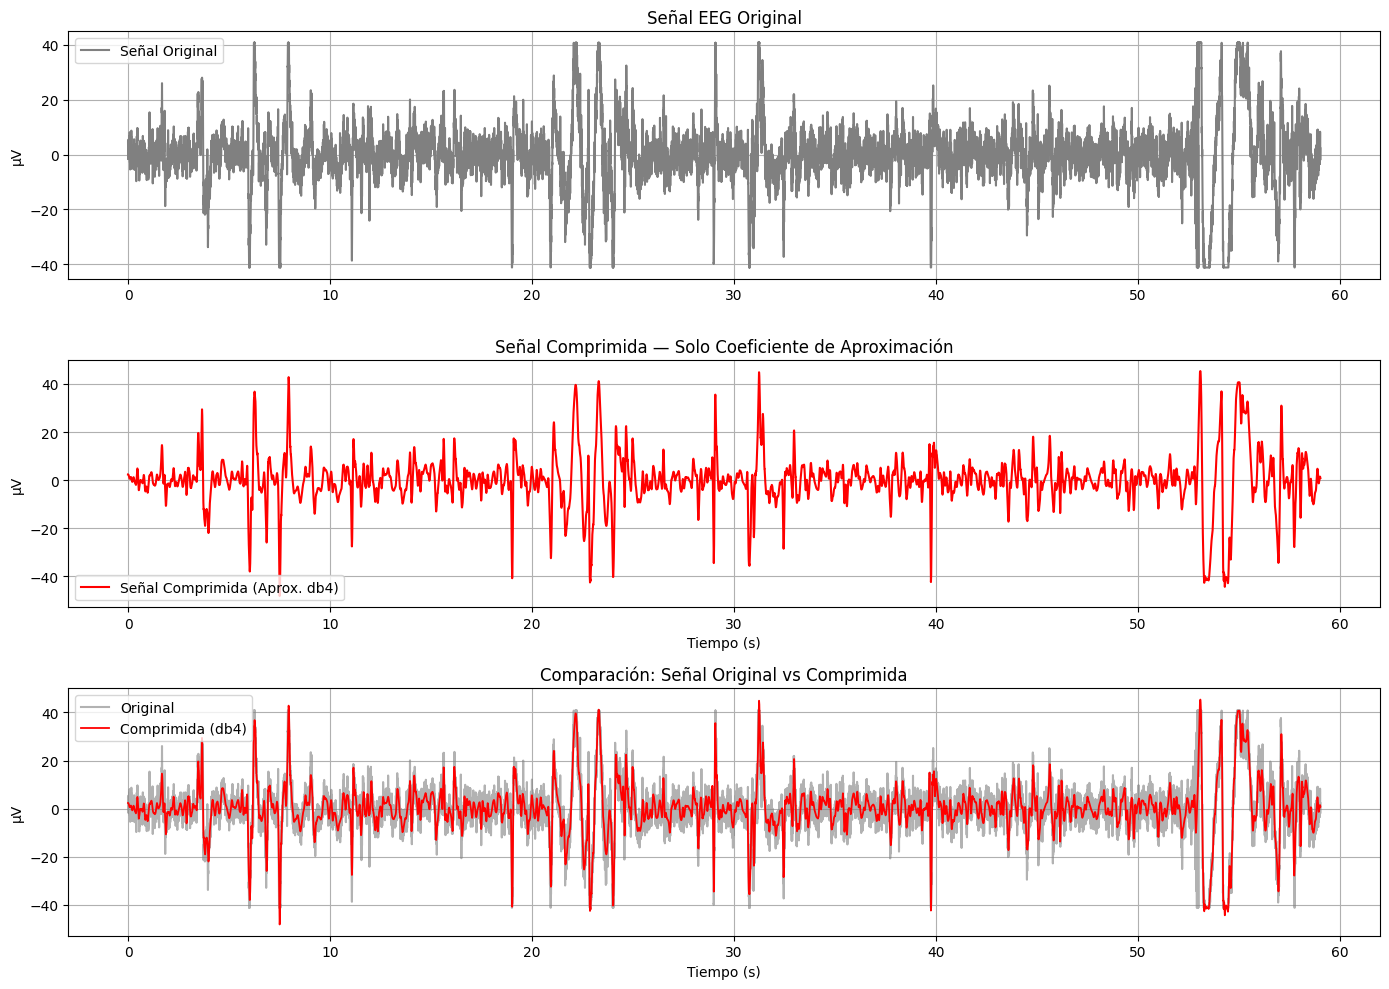

In [25]:
# Obtener los coeficientes de aproximación
coef_aproximacion = coeffs_umbral[0]

coeffs_zero = [np.zeros_like(c) for c in coeffs]
coeffs_zero[0] = coef_aproximacion

# Reconstruir la señal comprimida
senal_comprimida = pywt.waverec(coeffs_zero, 'db4')

# Obtener el tiempo correspondiente a los datos
t_1_2 = np.linspace(0, len(y_1)/1000, len(senal_comprimida))


# --- Graficar ---
plt.figure(figsize=(14, 10))

# 1. Señal original
plt.subplot(3, 1, 1)
plt.plot(t_1, y_1, label='Señal Original', color='gray')
plt.title('Señal EEG Original')
plt.ylabel('µV')
plt.grid(True)
plt.legend()

# 2️. Señal comprimida
plt.subplot(3, 1, 2)
plt.plot(t_1_2, senal_comprimida, label='Señal Comprimida (Aprox. db4)', color='red')
plt.title('Señal Comprimida — Solo Coeficiente de Aproximación')
plt.ylabel('µV')
plt.xlabel('Tiempo (s)')
plt.grid(True)
plt.legend()

# 3️. Comparación directa (superposición)
plt.subplot(3, 1, 3)
plt.plot(t_1, y_1, color='gray', alpha=0.6, label='Original')
plt.plot(t_1_2, senal_comprimida, color='red', linewidth=1.3, label='Comprimida (db4)')
plt.title('Comparación: Señal Original vs Comprimida')
plt.xlabel('Tiempo (s)')
plt.ylabel('µV')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


## Filtrar señal con Wavelet (sym4)

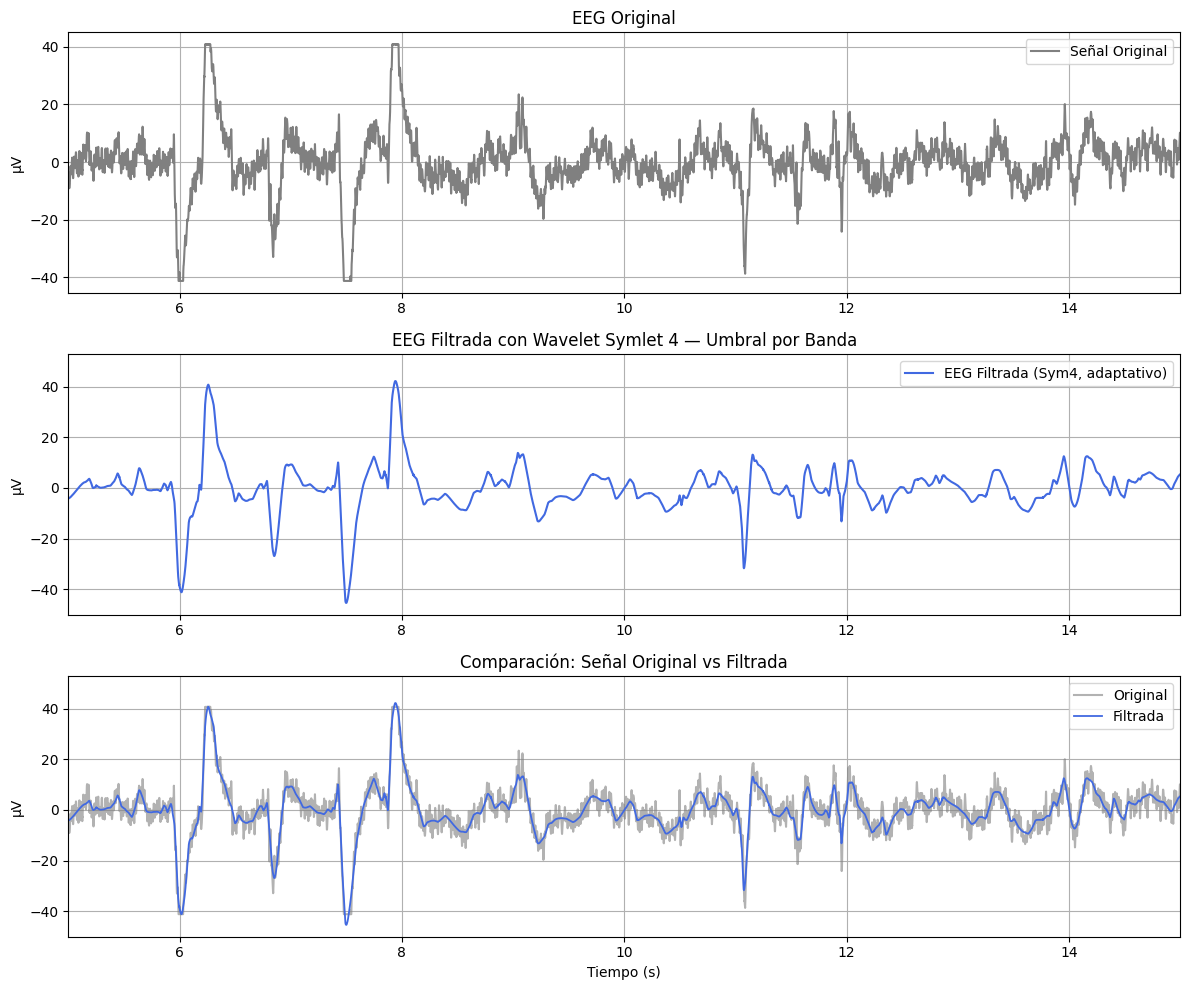

In [26]:
# --- Descomposición en wavelets ---
wavelet = 'sym4'
nivel = 6
coeffs = pywt.wavedec(y_1, wavelet, level=nivel)

# --- Frecuencia de muestreo ---
fs = 1000  # Hz

# --- Bandas EEG aproximadas según nivel (para fs = 1000 Hz y nivel=6) ---
bandas = {
    6: "A6 (0–8 Hz) δ+θ",
    5: "D6 (8–16 Hz) α",
    4: "D5 (16–32 Hz) β",
    3: "D4 (32–64 Hz) γ baja",
    2: "D3 (64–128 Hz) γ alta",
    1: "D2 (128–256 Hz) ruido",
    0: "D1 (>256 Hz) ruido eléctrico"
}

# --- Cálculo de umbral adaptativo por nivel ---
coeffs_umbral = []
for i, c in enumerate(coeffs):
    if i == 0:
        # A6 → componente más lenta (delta + theta)
        # No se filtra agresivamente
        coeffs_umbral.append(c)
    else:
        # Estimación del ruido y umbral tipo VisuShrink
        sigma = np.median(np.abs(c)) / 0.6745
        T = sigma * np.sqrt(2 * np.log(len(c)))

        # Nota: i=1 → D6, i=6 → D1 (orden inverso en PyWavelets)
        if i == 1:  # D6 (alfa, 8–16 Hz)
            T *= 0.3  # conservar más señal
        elif i == 2:  # D5 (beta, 16–32 Hz)
            T *= 0.6
        elif i == 3:  # D4 (gamma baja)
            T *= 0.8
        elif i == 4:  # D3 (gamma alta)
            T *= 1
        elif i >= 5:  # D2-D1 (ruido)
            T *= 1.5  # filtrar más agresivo

        # Aplicar umbral suave
        coeffs_umbral.append(pywt.threshold(c, T, mode='soft'))

# --- Reconstrucción de la señal filtrada ---
senal_denoised = pywt.waverec(coeffs_umbral, wavelet)

# --- Gráficas ---
plt.figure(figsize=(12, 10))

# 1️ Señal original
plt.subplot(3, 1, 1)
plt.plot(t_1, y_1, color='gray', label='Señal Original')
plt.title('EEG Original')
plt.xlim(5, 15)
plt.ylabel('µV')
plt.grid(True)
plt.legend()

# 2️ Señal filtrada
plt.subplot(3, 1, 2)
plt.plot(t_1, senal_denoised, color='royalblue', label='EEG Filtrada (Sym4, adaptativo)')
plt.title('EEG Filtrada con Wavelet Symlet 4 — Umbral por Banda')
plt.xlim(5, 15)
plt.ylabel('µV')
plt.grid(True)
plt.legend()

# 3️ Comparación directa
plt.subplot(3, 1, 3)
plt.plot(t_1, y_1, color='gray', alpha=0.6, label='Original')
plt.plot(t_1, senal_denoised, color='royalblue', linewidth=1.3, label='Filtrada')
plt.title('Comparación: Señal Original vs Filtrada')
plt.xlim(5, 15)
plt.xlabel('Tiempo (s)')
plt.ylabel('µV')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

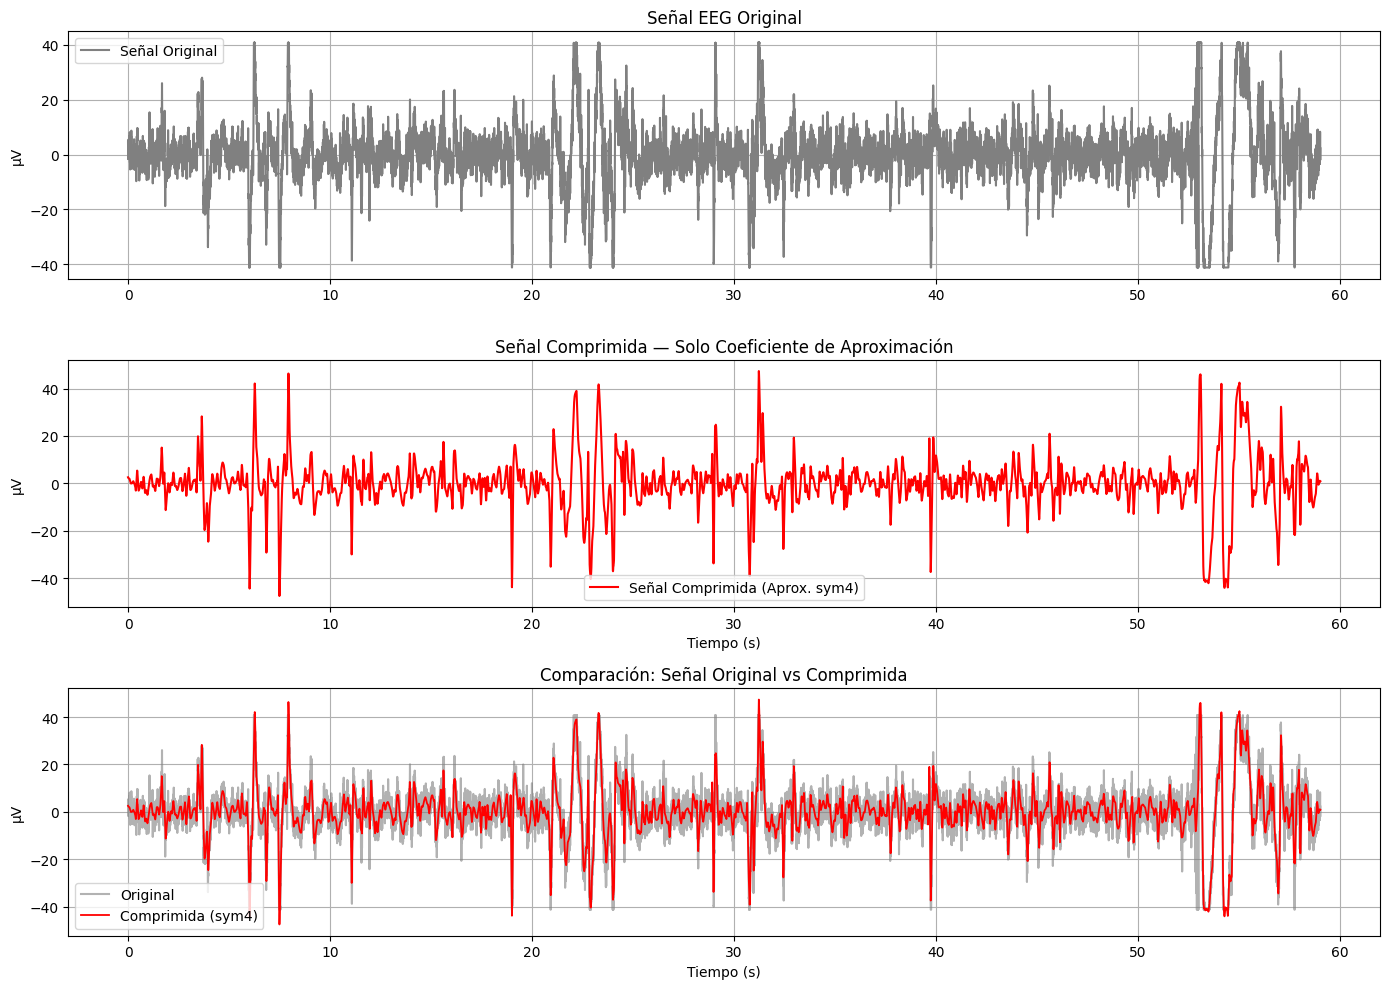

In [27]:
# Obtener los coeficientes de aproximación
coef_aproximacion = coeffs_umbral[0]

coeffs_zero = [np.zeros_like(c) for c in coeffs]
coeffs_zero[0] = coef_aproximacion

# Reconstruir la señal comprimida
senal_comprimida = pywt.waverec(coeffs_zero, 'sym4')

# Obtener el tiempo correspondiente a los datos
t_1_2 = np.linspace(0, len(y_1)/1000, len(senal_comprimida))


# --- Graficar ---
plt.figure(figsize=(14, 10))

# 1. Señal original
plt.subplot(3, 1, 1)
plt.plot(t_1, y_1, label='Señal Original', color='gray')
plt.title('Señal EEG Original')
plt.ylabel('µV')
plt.grid(True)
plt.legend()

# 2️. Señal comprimida
plt.subplot(3, 1, 2)
plt.plot(t_1_2, senal_comprimida, label='Señal Comprimida (Aprox. sym4)', color='red')
plt.title('Señal Comprimida — Solo Coeficiente de Aproximación')
plt.ylabel('µV')
plt.xlabel('Tiempo (s)')
plt.grid(True)
plt.legend()

# 3️. Comparación directa (superposición)
plt.subplot(3, 1, 3)
plt.plot(t_1, y_1, color='gray', alpha=0.6, label='Original')
plt.plot(t_1_2, senal_comprimida, color='red', linewidth=1.3, label='Comprimida (sym4)')
plt.title('Comparación: Señal Original vs Comprimida')
plt.xlabel('Tiempo (s)')
plt.ylabel('µV')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


## B) Análisis para señal: Ojos cerrados

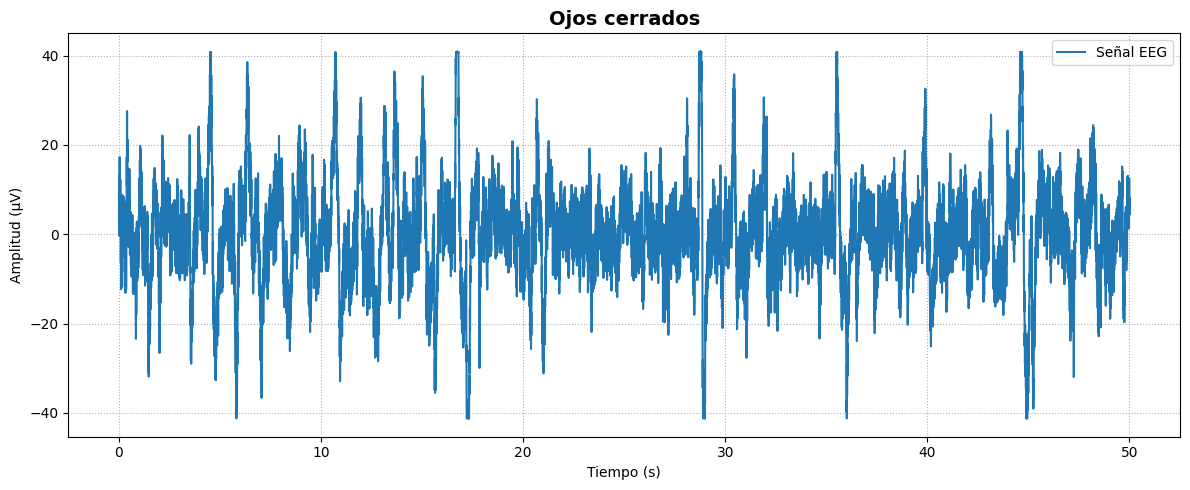

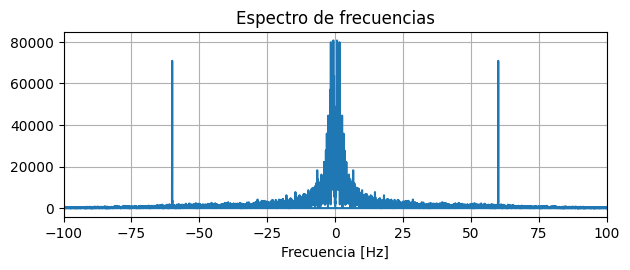

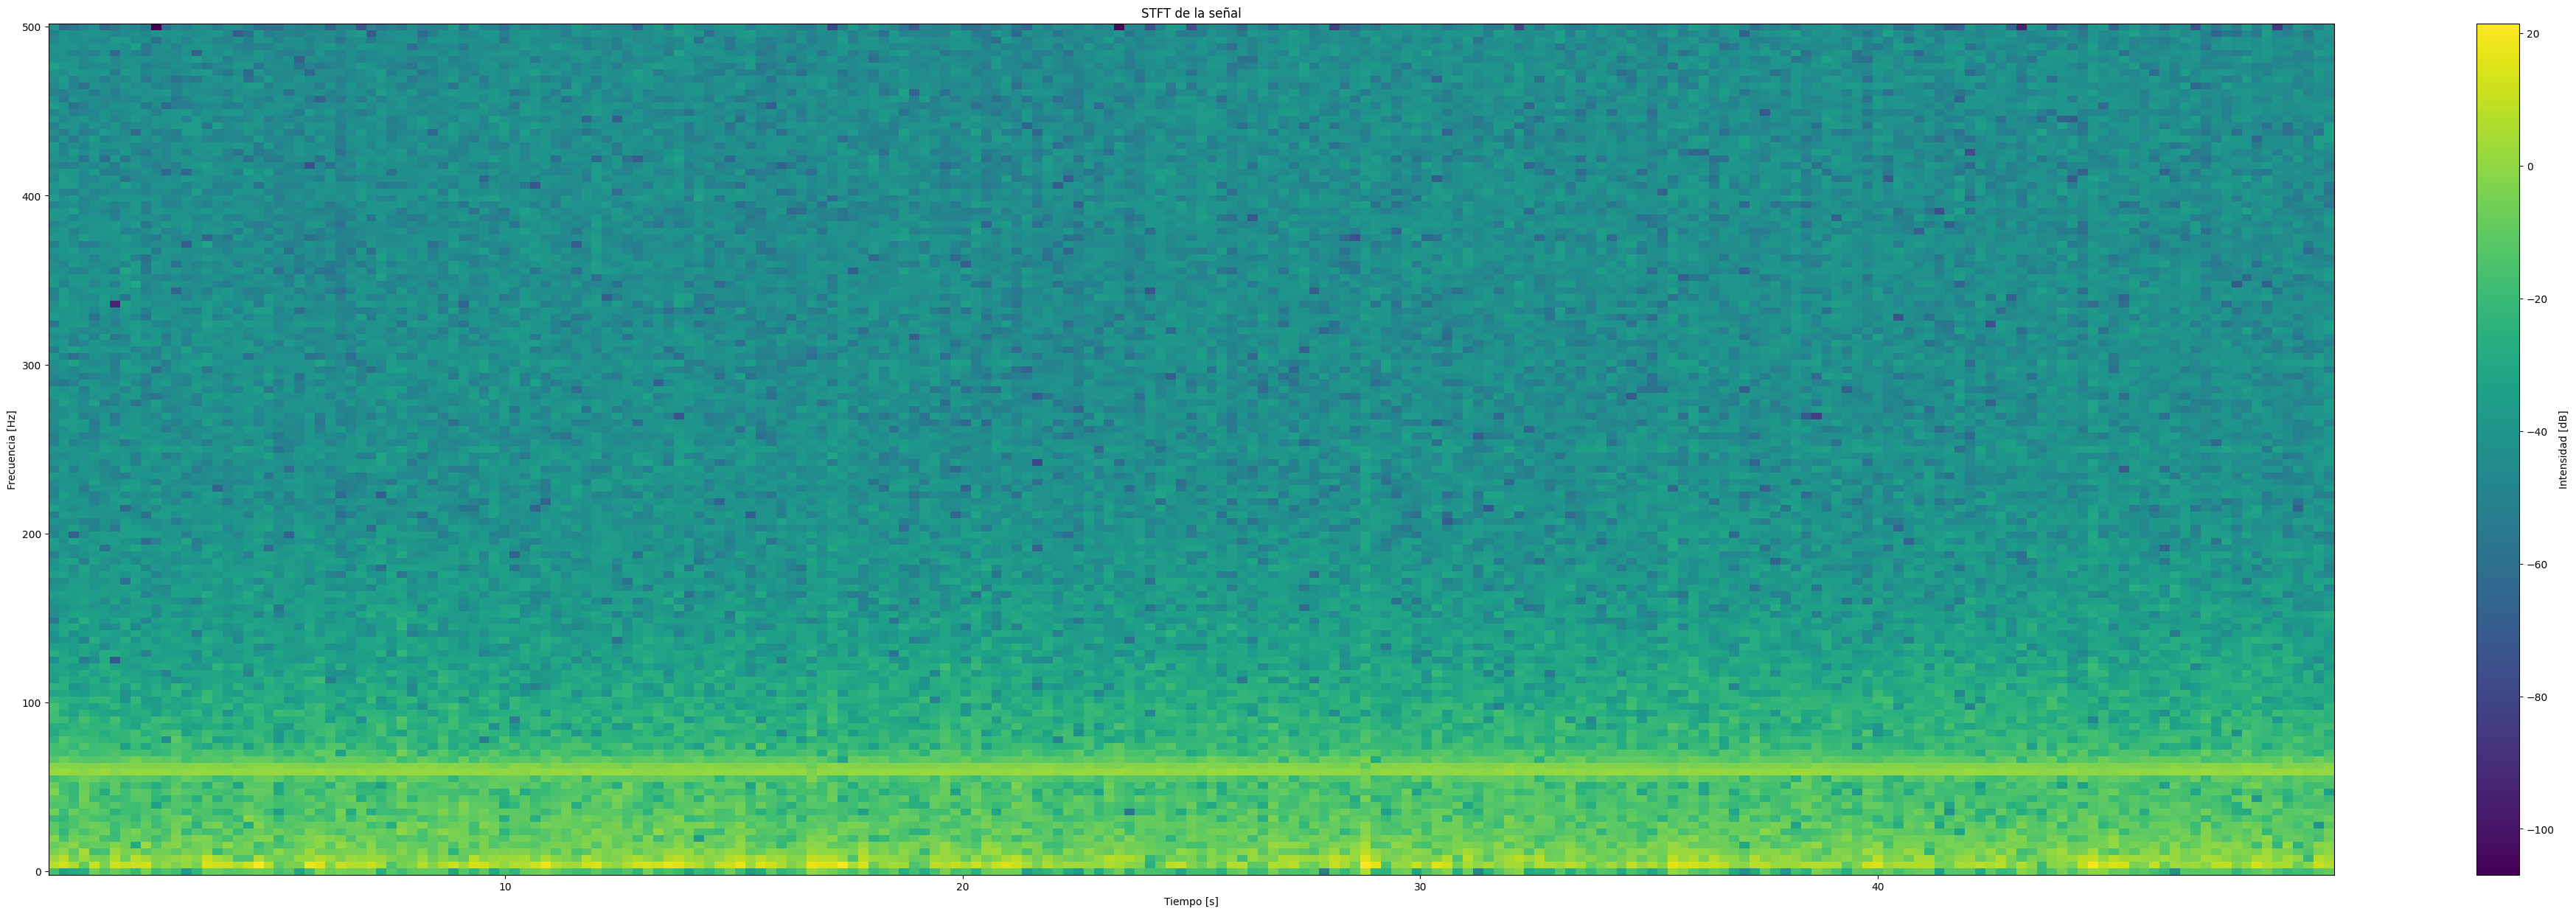

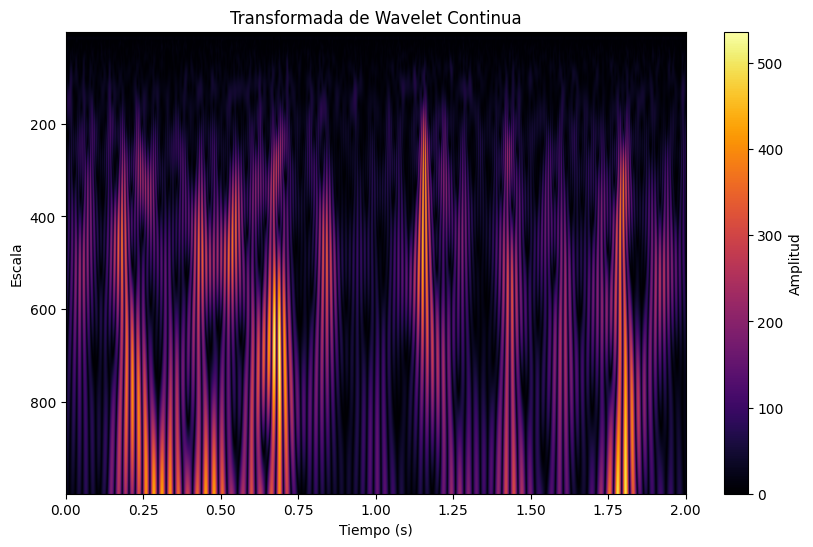

¿coinciden frecuencias?  True


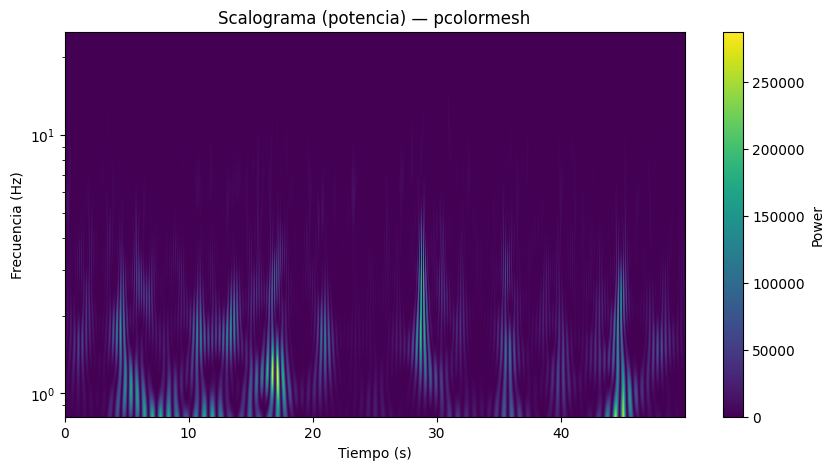

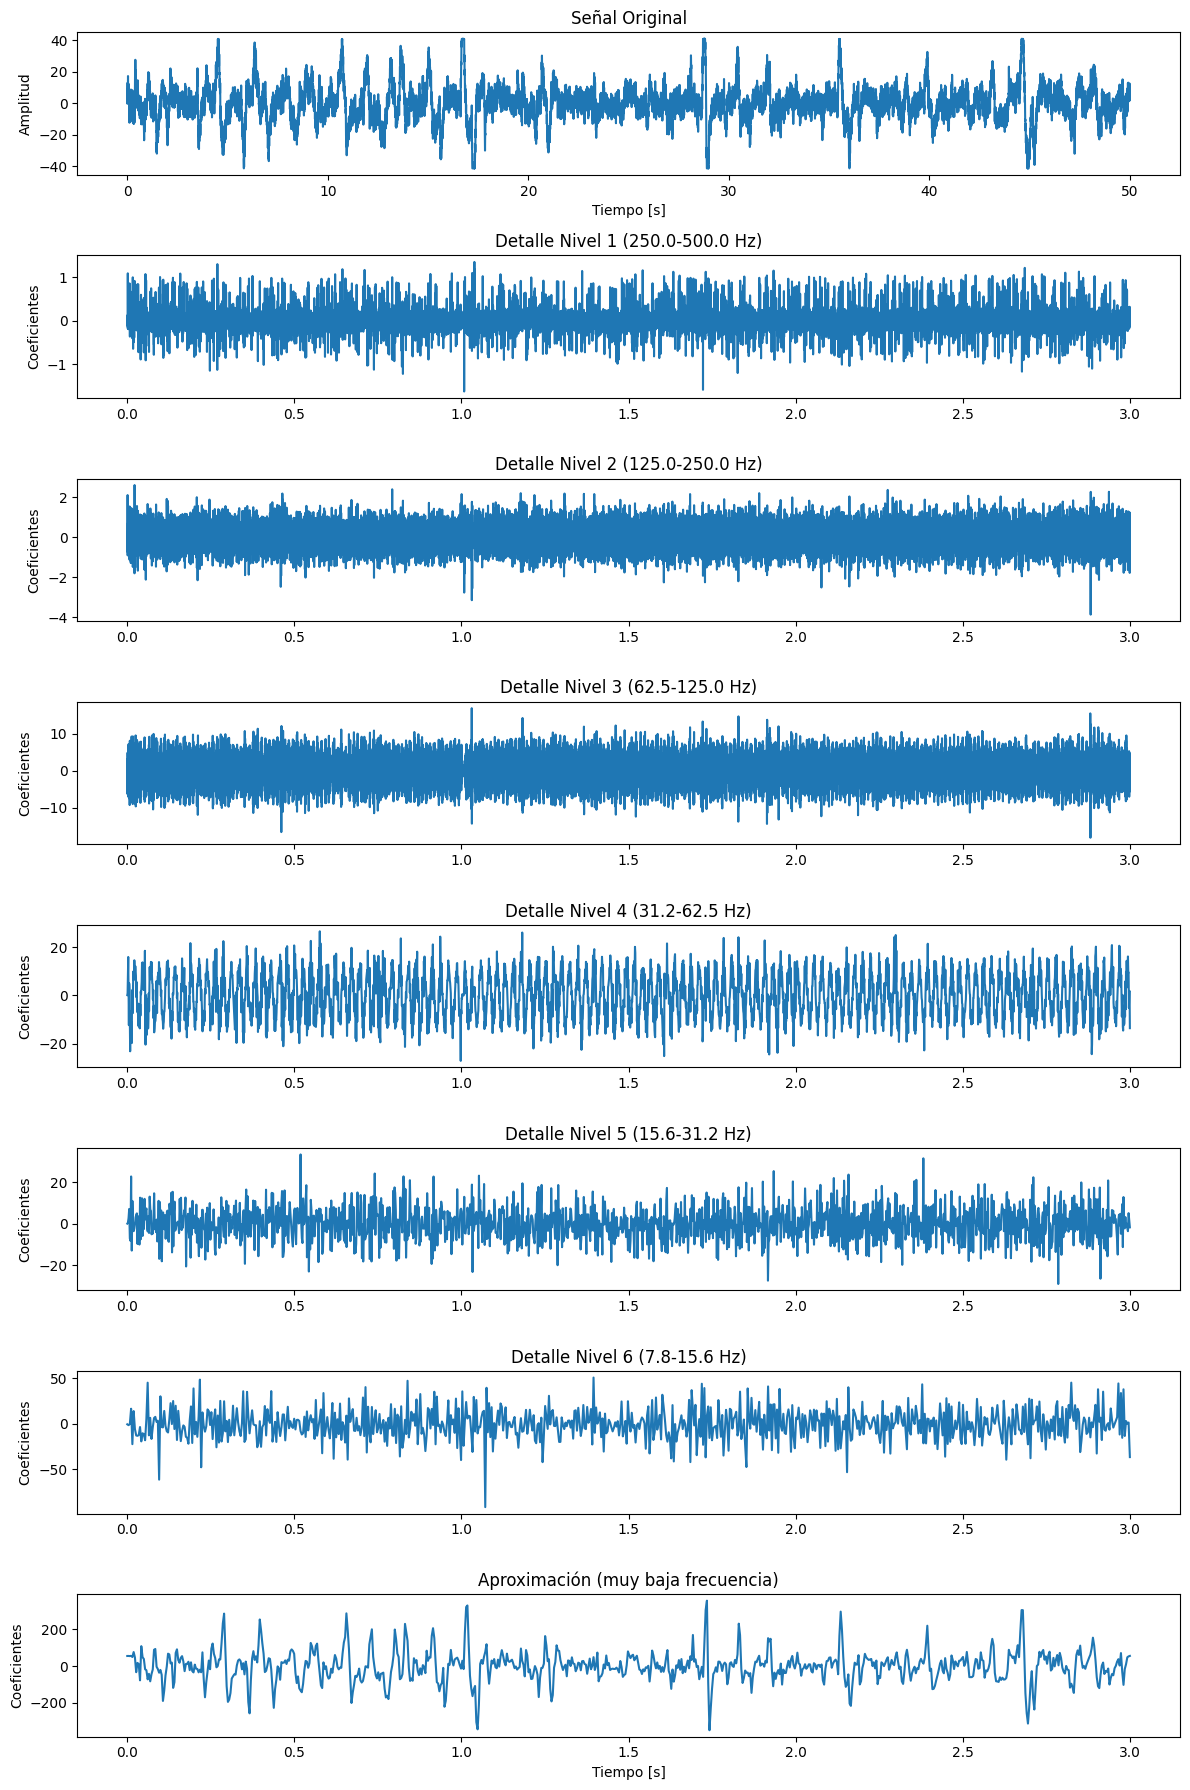

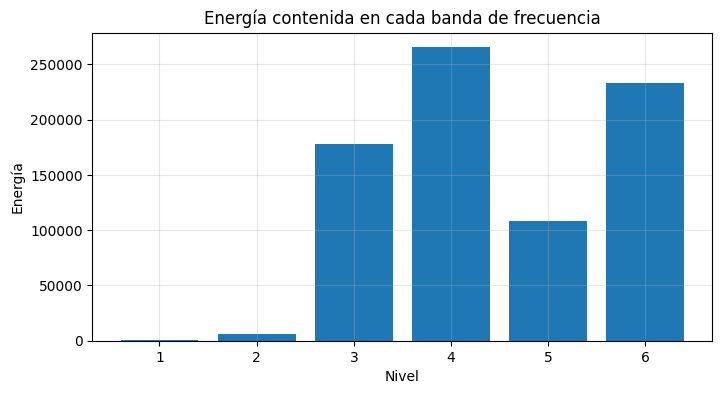

Nivel 1: 250.00 - 500.00 Hz | Energía = 931.11
Nivel 2: 125.00 - 250.00 Hz | Energía = 5878.18
Nivel 3: 62.50 - 125.00 Hz | Energía = 177568.22
Nivel 4: 31.25 - 62.50 Hz | Energía = 265365.78
Nivel 5: 15.62 - 31.25 Hz | Energía = 108435.74
Nivel 6: 7.81 - 15.62 Hz | Energía = 233494.52


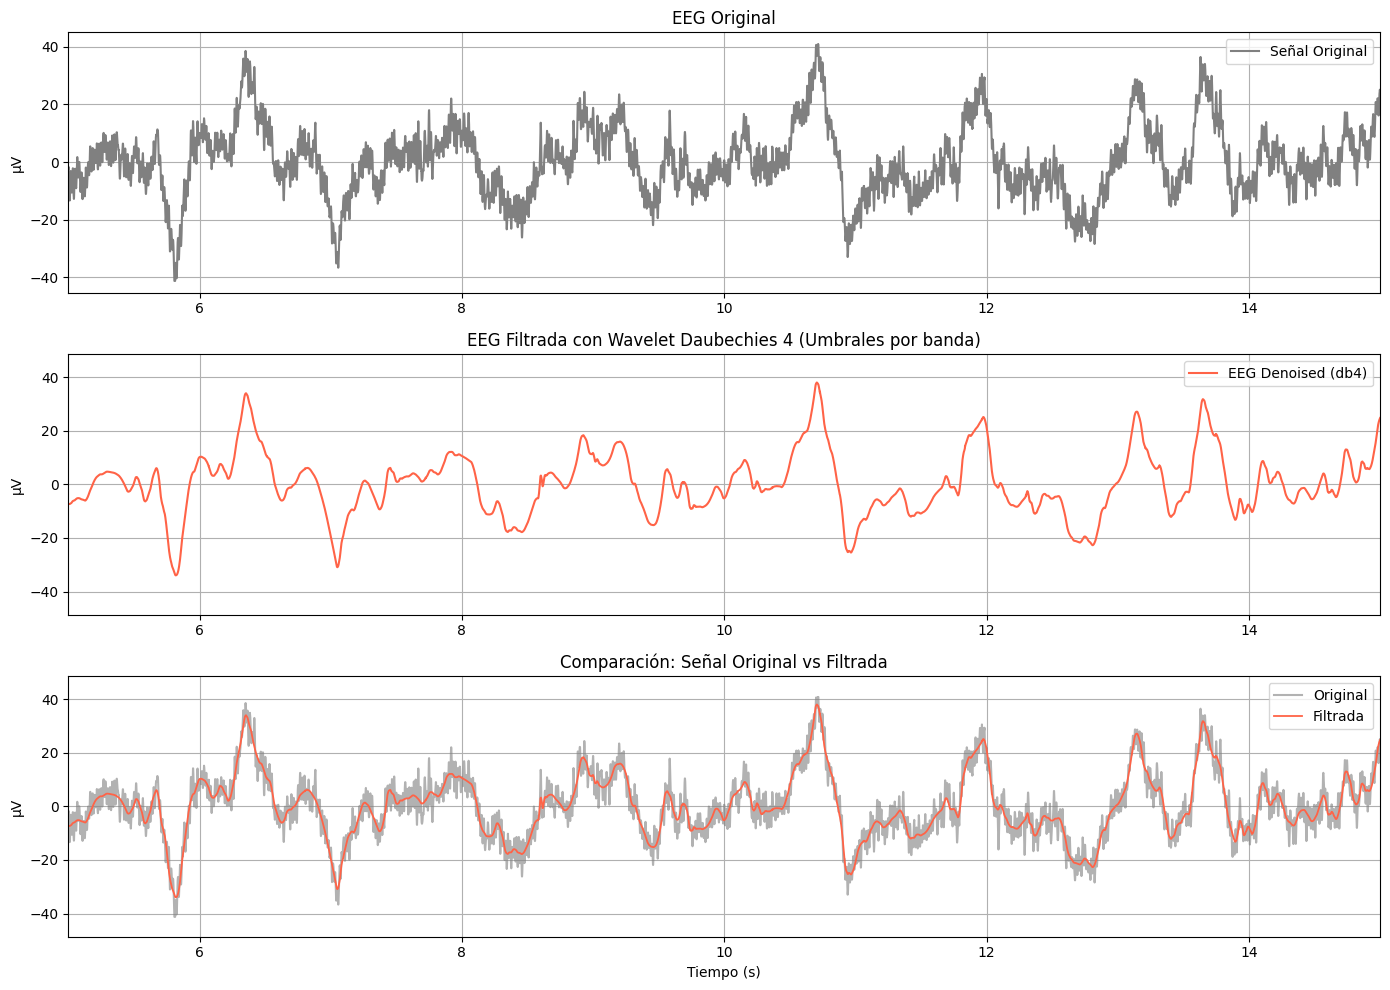

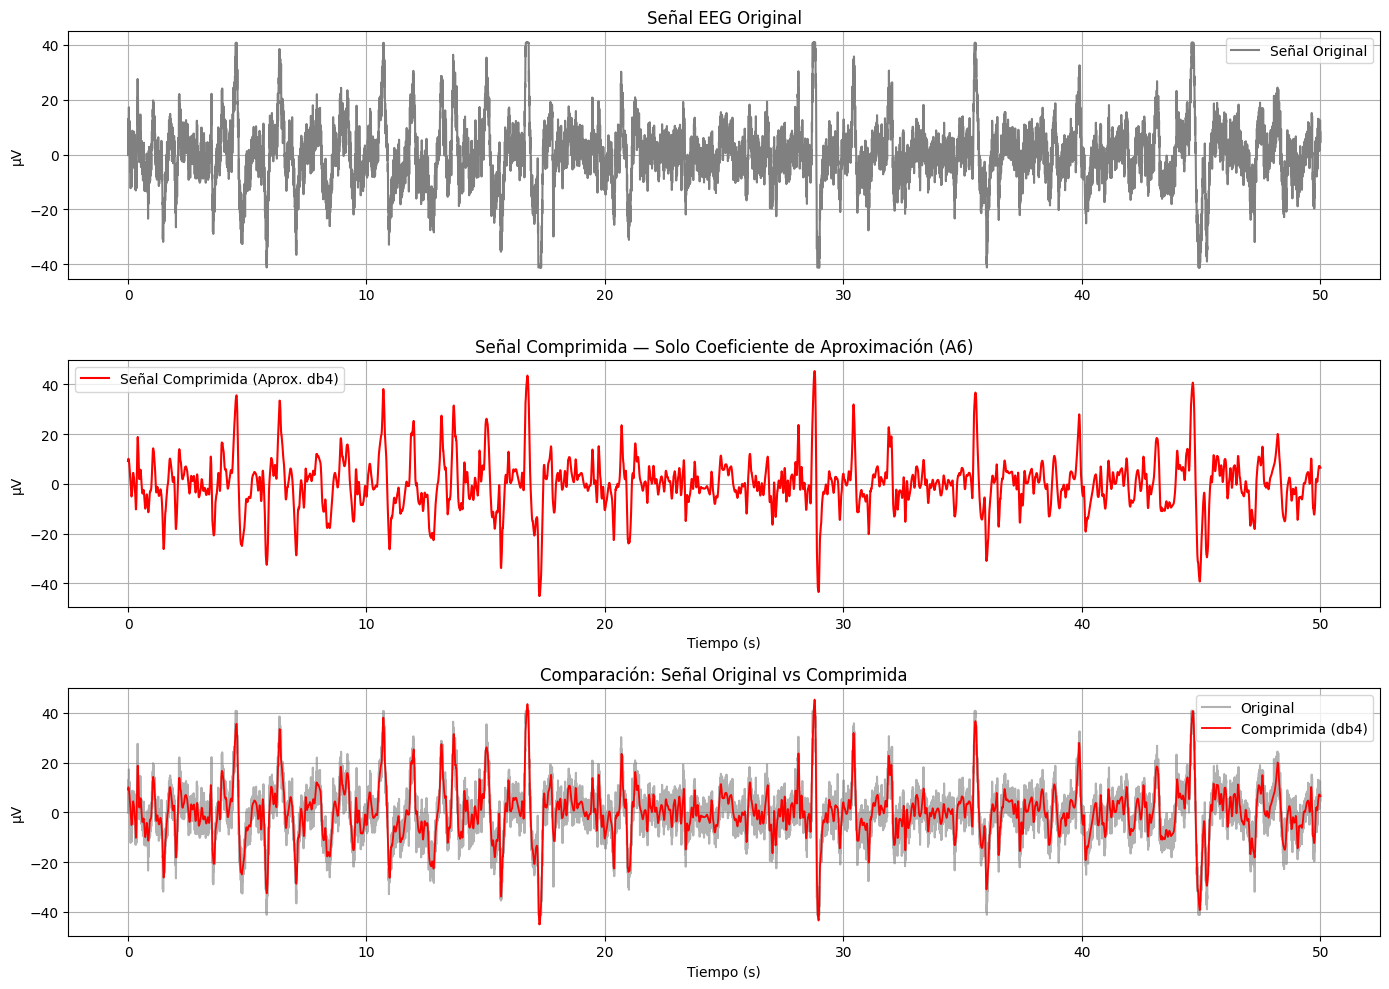

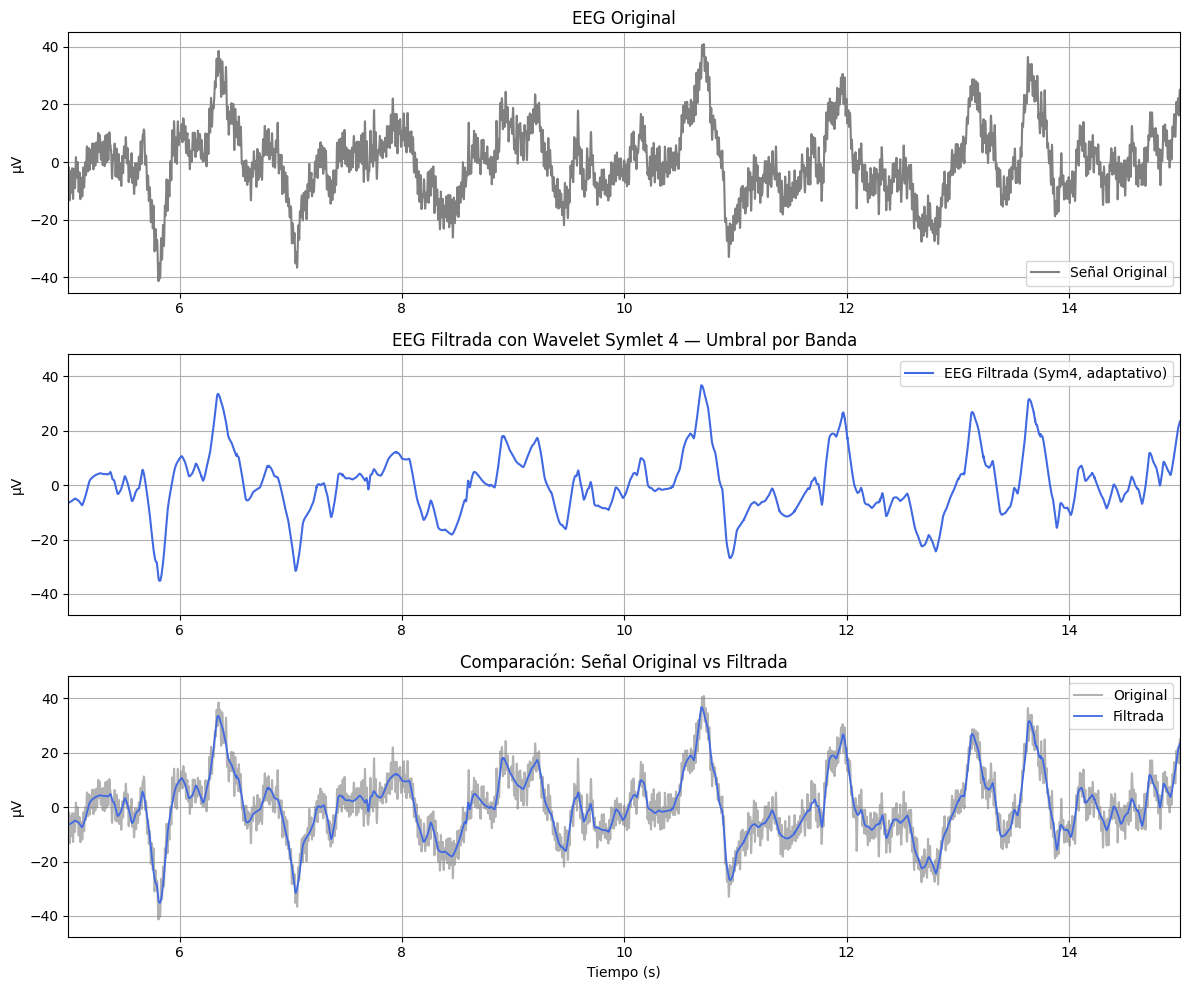

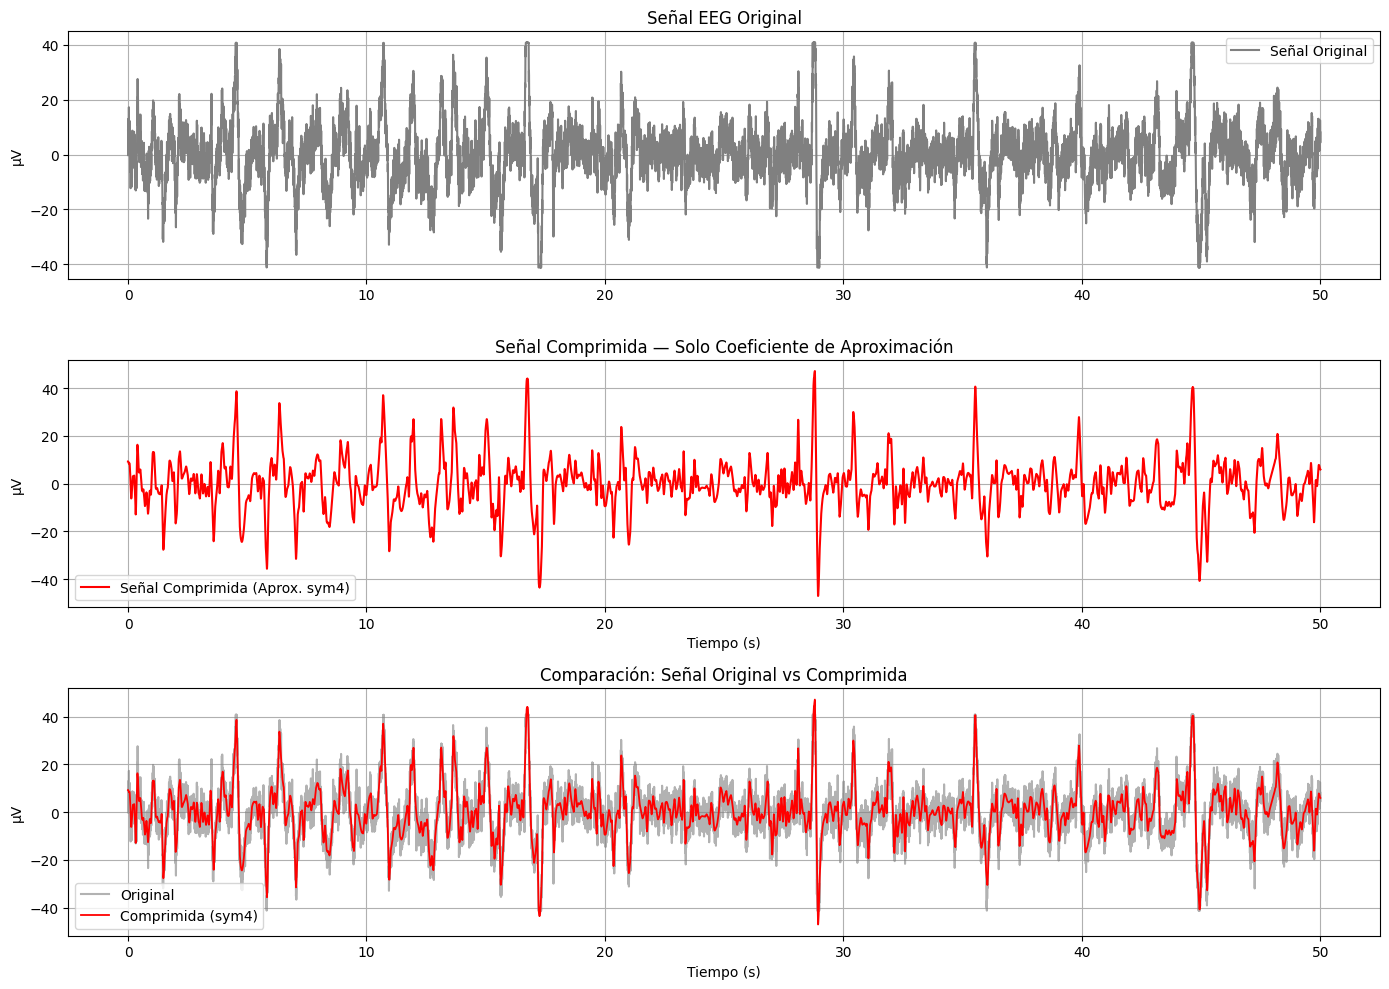

In [28]:
# --- Gráfico de la señal EEG ---
plt.figure(figsize=(12, 5))
plt.plot(t_2, y_2, label="Señal EEG")
plt.title("Ojos cerrados", fontsize=14, fontweight='bold', loc='center')
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud (µV)")
plt.grid(linestyle=":")
plt.legend()
plt.tight_layout()
plt.show()

## DFT
X = np.fft.fft(y_2)
frequencies = np.fft.fftfreq(len(y_2), 1/fs)

plt.subplot(2, 1, 2)
plt.plot(frequencies, np.abs(X))
plt.title('Espectro de frecuencias')
plt.xlabel('Frecuencia [Hz]')
plt.grid()
plt.xlim([-100, 100])
plt.tight_layout()
plt.show()

## STFT
f, t, Sxx = spectrogram(y_2, fs)
plt.figure(figsize=(50, 15))
plt.pcolormesh(t, f, 10 * np.log10(Sxx))
plt.title('STFT de la señal')
plt.ylabel('Frecuencia [Hz]')
plt.xlabel('Tiempo [s]')
plt.colorbar(label='Intensidad [dB]')
plt.show()

# Transformada de Wavelet Continua (CWT)
escala = np.arange(1, 1000)
coeficientes, frecuencias = pywt.cwt(y_2, escala, 'morl',sampling_period=1/1000)
plt.figure(figsize=(10, 6))
plt.imshow(np.abs(coeficientes), extent=[0, 2, escala[-1], escala[0]], aspect='auto', cmap='inferno')
plt.colorbar(label='Amplitud')
plt.title('Transformada de Wavelet Continua')
plt.xlabel('Tiempo (s)')
plt.ylabel('Escala')
plt.show()

freqs_check = pywt.scale2frequency('morl', escala) * fs
print("¿coinciden frecuencias? ", np.allclose(frecuencias, freqs_check))
power = np.abs(coeficientes)**2
power_norm = power / np.sqrt(escala)[:, None]
plt.figure(figsize=(10,5))
plt.pcolormesh(t_2, frecuencias, power, shading='auto');
plt.ylabel('Frecuencia (Hz)')
plt.xlabel('Tiempo (s)')
plt.yscale('log')
plt.title('Scalograma (potencia) — pcolormesh')
plt.colorbar(label='Power')
plt.ylim(frecuencias.min(),25)
plt.show()


# Transformada de Wavelet Discreta (DWT)

wavelet = 'db4'
niveles = 6
coeficientes = pywt.wavedec(y_2, wavelet, level=niveles)
detalles = coeficientes[1:][::-1]
energias = [np.sum(np.square(c)) for c in detalles]
bandas = [(fs / (2 ** (i + 1)), fs / (2 ** i)) for i in range(1, niveles + 1)]
plt.figure(figsize=(12, 18))
plt.subplot(niveles + 2, 1, 1)
plt.plot(t_2, y_2)
plt.title('Señal Original')
plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud')

# Graficar los niveles 1 → n (altas → bajas)
for i, c in enumerate(detalles, start=1):
    t_c = np.linspace(0, 3, len(c))  # eje temporal aproximado
    plt.subplot(niveles + 2, 1, i + 1)
    plt.plot(t_c, c)
    plt.title(f'Detalle Nivel {i} ({bandas[i-1][0]:.1f}-{bandas[i-1][1]:.1f} Hz)')
    plt.ylabel('Coeficientes')

# Aproximación final
t_a = np.linspace(0, 3, len(coeficientes[0]))
plt.subplot(niveles + 2, 1, niveles + 2)
plt.plot(t_a, coeficientes[0])
plt.title('Aproximación (muy baja frecuencia)')
plt.xlabel('Tiempo [s]')
plt.ylabel('Coeficientes')
plt.tight_layout()
plt.show()

#Energía por nivel
plt.figure(figsize=(8, 4))
niveles_list = np.arange(1, niveles + 1)
plt.bar(niveles_list, energias)
plt.xlabel('Nivel')
plt.ylabel('Energía')
plt.title('Energía contenida en cada banda de frecuencia')
plt.xticks(niveles_list)
plt.grid(True, alpha=0.3)
plt.show()

# Tabla resumen
for i, (f_low, f_high) in enumerate(bandas):
    print(f"Nivel {i+1}: {f_low:.2f} - {f_high:.2f} Hz | Energía = {energias[i]:.2f}")


## Filtrar señal con Wavelet (db4)
# --- Descomposición wavelet ---
wavelet = 'db4'
nivel = 6
coeffs = pywt.wavedec(y_2, wavelet, level=nivel)

# --- Parámetros generales ---
fs = 1000  # Hz (frecuencia de muestreo)

# --- Aplicar umbrales manuales según banda EEG ---
coeffs_umbral = []
for i, c in enumerate(coeffs):
    if i == 0:
        # A6 → componente más lenta (delta + theta)
        # No se filtra agresivamente
        coeffs_umbral.append(c)
    else:
        # Estimación del ruido y umbral tipo VisuShrink
        sigma = np.median(np.abs(c)) / 0.6745
        T = sigma * np.sqrt(2 * np.log(len(c)))

        # Nota: i=1 → D6, i=6 → D1 (orden inverso en PyWavelets)
        if i == 1:  # D6 (alfa, 8–16 Hz)
            T *= 0.3  # conservar más señal
        elif i == 2:  # D5 (beta, 16–32 Hz)
            T *= 0.6
        elif i == 3:  # D4 (gamma baja)
            T *= 0.8
        elif i == 4:  # D3 (gamma alta)
            T *= 1
        elif i >= 5:  # D2-D1 (ruido)
            T *= 1.5  # filtrar más agresivo

        # Aplicar umbral suave
        coeffs_umbral.append(pywt.threshold(c, T, mode='soft'))

# --- Reconstrucción denoised ---
senal_denoised = pywt.waverec(coeffs_umbral, wavelet)
senal_denoised = senal_denoised[:len(y_2)]  # ajustar tamaño si varía

# --- Asignar bandas EEG aproximadas ---
bandas = ['A6 (δ+θ 0–8 Hz)', 'D6 (α 8–16 Hz)', 'D5 (β 16–32 Hz)',
          'D4 (γ baja 32–64 Hz)', 'D3 (γ alta 64–128 Hz)',
          'D2 (ruido muscular 128–256 Hz)', 'D1 (ruido >256 Hz)']

# --- Gráficas comparativas ---
plt.figure(figsize=(14, 10))

# Señal original
plt.subplot(3, 1, 1)
plt.plot(t_2, y_2, color='gray', label='Señal Original')
plt.title('EEG Original')
plt.xlim(5, 15)
plt.ylabel('µV')
plt.grid(True)
plt.legend()

# Señal denoised
plt.subplot(3, 1, 2)
plt.plot(t_2, senal_denoised, color='tomato', label='EEG Denoised (db4)')
plt.title('EEG Filtrada con Wavelet Daubechies 4 (Umbrales por banda)')
plt.xlim(5, 15)
plt.ylabel('µV')
plt.grid(True)
plt.legend()

# Comparación directa
plt.subplot(3, 1, 3)
plt.plot(t_2, y_2, color='gray', alpha=0.6, label='Original')
plt.plot(t_2, senal_denoised, color='tomato', linewidth=1.3, label='Filtrada')
plt.title('Comparación: Señal Original vs Filtrada')
plt.xlim(5, 15)
plt.xlabel('Tiempo (s)')
plt.ylabel('µV')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


# --- Compresión usando solo el coeficiente de aproximación (A6) ---
coef_aproximacion = coeffs_umbral[0]
coeffs_zero = [np.zeros_like(c) for c in coeffs]
coeffs_zero[0] = coef_aproximacion
senal_comprimida = pywt.waverec(coeffs_zero, wavelet)
t_2_2 = np.linspace(0, len(y_2)/fs, len(senal_comprimida))  # tiempo

# --- Gráficas de compresión ---
plt.figure(figsize=(14, 10))

# 1. Señal original
plt.subplot(3, 1, 1)
plt.plot(t_2, y_2, label='Señal Original', color='gray')
plt.title('Señal EEG Original')
plt.ylabel('µV')
plt.grid(True)
plt.legend()

# 2️. Señal comprimida
plt.subplot(3, 1, 2)
plt.plot(t_2_2, senal_comprimida, label='Señal Comprimida (Aprox. db4)', color='red')
plt.title('Señal Comprimida — Solo Coeficiente de Aproximación (A6)')
plt.ylabel('µV')
plt.xlabel('Tiempo (s)')
plt.grid(True)
plt.legend()

# 3️. Comparación directa (superposición)
plt.subplot(3, 1, 3)
plt.plot(t_2, y_2, color='gray', alpha=0.6, label='Original')
plt.plot(t_2_2, senal_comprimida, color='red', linewidth=1.3, label='Comprimida (db4)')
plt.title('Comparación: Señal Original vs Comprimida')
plt.xlabel('Tiempo (s)')
plt.ylabel('µV')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

## Filtrar señal con Wavelet (sym4)
# --- Descomposición en wavelets ---
wavelet = 'sym4'
nivel = 6
coeffs = pywt.wavedec(y_2, wavelet, level=nivel)

# --- Frecuencia de muestreo ---
fs = 1000  # Hz

# --- Bandas EEG aproximadas según nivel (para fs = 1000 Hz y nivel=6) ---
bandas = {
    6: "A6 (0–8 Hz) δ+θ",
    5: "D6 (8–16 Hz) α",
    4: "D5 (16–32 Hz) β",
    3: "D4 (32–64 Hz) γ baja",
    2: "D3 (64–128 Hz) γ alta",
    1: "D2 (128–256 Hz) ruido",
    0: "D1 (>256 Hz) ruido eléctrico"
}

# --- Cálculo de umbral adaptativo por nivel ---
coeffs_umbral = []
for i, c in enumerate(coeffs):
    if i == 0:
        # A6 → componente más lenta (delta + theta)
        # No se filtra agresivamente
        coeffs_umbral.append(c)
    else:
        # Estimación del ruido y umbral tipo VisuShrink
        sigma = np.median(np.abs(c)) / 0.6745
        T = sigma * np.sqrt(2 * np.log(len(c)))
        # Nota: i=1 → D6, i=6 → D1 (orden inverso en PyWavelets)
        if i == 1:  # D6 (alfa, 8–16 Hz)
            T *= 0.3  # conservar más señal
        elif i == 2:  # D5 (beta, 16–32 Hz)
            T *= 0.6
        elif i == 3:  # D4 (gamma baja)
            T *= 0.8
        elif i == 4:  # D3 (gamma alta)
            T *= 1
        elif i >= 5:  # D2-D1 (ruido)
            T *= 1.5  # filtrar más agresivo

        # Aplicar umbral suave
        coeffs_umbral.append(pywt.threshold(c, T, mode='soft'))

# --- Reconstrucción de la señal filtrada ---
senal_denoised = pywt.waverec(coeffs_umbral, wavelet)

# --- Gráficas ---
plt.figure(figsize=(12, 10))

# 1️ Señal original
plt.subplot(3, 1, 1)
plt.plot(t_2, y_2, color='gray', label='Señal Original')
plt.title('EEG Original')
plt.xlim(5, 15)
plt.ylabel('µV')
plt.grid(True)
plt.legend()

# 2️ Señal filtrada
plt.subplot(3, 1, 2)
plt.plot(t_2, senal_denoised, color='royalblue', label='EEG Filtrada (Sym4, adaptativo)')
plt.title('EEG Filtrada con Wavelet Symlet 4 — Umbral por Banda')
plt.xlim(5, 15)
plt.ylabel('µV')
plt.grid(True)
plt.legend()

# 3️ Comparación directa
plt.subplot(3, 1, 3)
plt.plot(t_2, y_2, color='gray', alpha=0.6, label='Original')
plt.plot(t_2, senal_denoised, color='royalblue', linewidth=1.3, label='Filtrada')
plt.title('Comparación: Señal Original vs Filtrada')
plt.xlim(5, 15)
plt.xlabel('Tiempo (s)')
plt.ylabel('µV')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


coef_aproximacion = coeffs_umbral[0]
coeffs_zero = [np.zeros_like(c) for c in coeffs]
coeffs_zero[0] = coef_aproximacion
senal_comprimida = pywt.waverec(coeffs_zero, 'sym4')
t_2_2 = np.linspace(0, len(y_2)/1000, len(senal_comprimida))  # Suponiendo que la frecuencia de muestreo es 1000 Hz


# --- Graficar ---
plt.figure(figsize=(14, 10))

# 1. Señal original
plt.subplot(3, 1, 1)
plt.plot(t_2, y_2, label='Señal Original', color='gray')
plt.title('Señal EEG Original')
plt.ylabel('µV')
plt.grid(True)
plt.legend()

# 2️. Señal comprimida
plt.subplot(3, 1, 2)
plt.plot(t_2_2, senal_comprimida, label='Señal Comprimida (Aprox. sym4)', color='red')
plt.title('Señal Comprimida — Solo Coeficiente de Aproximación')
plt.ylabel('µV')
plt.xlabel('Tiempo (s)')
plt.grid(True)
plt.legend()

# 3️. Comparación directa (superposición)
plt.subplot(3, 1, 3)
plt.plot(t_2, y_2, color='gray', alpha=0.6, label='Original')
plt.plot(t_2_2, senal_comprimida, color='red', linewidth=1.3, label='Comprimida (sym4)')
plt.title('Comparación: Señal Original vs Comprimida')
plt.xlabel('Tiempo (s)')
plt.ylabel('µV')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



## C) Análisis para señal: Tarea cognitiva

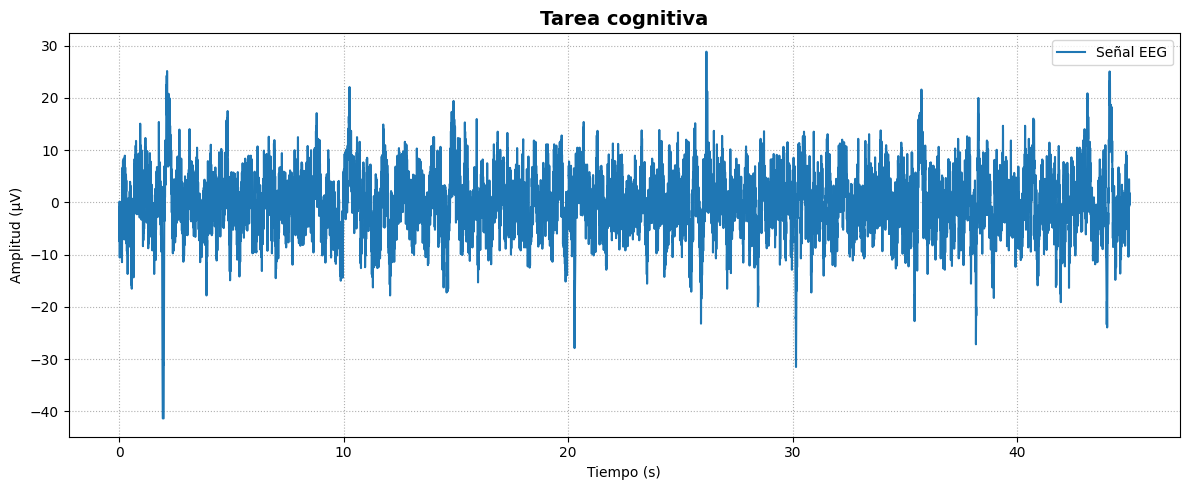

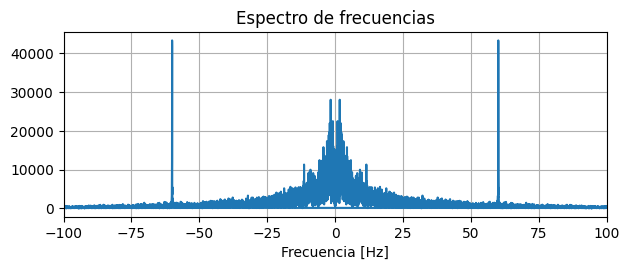

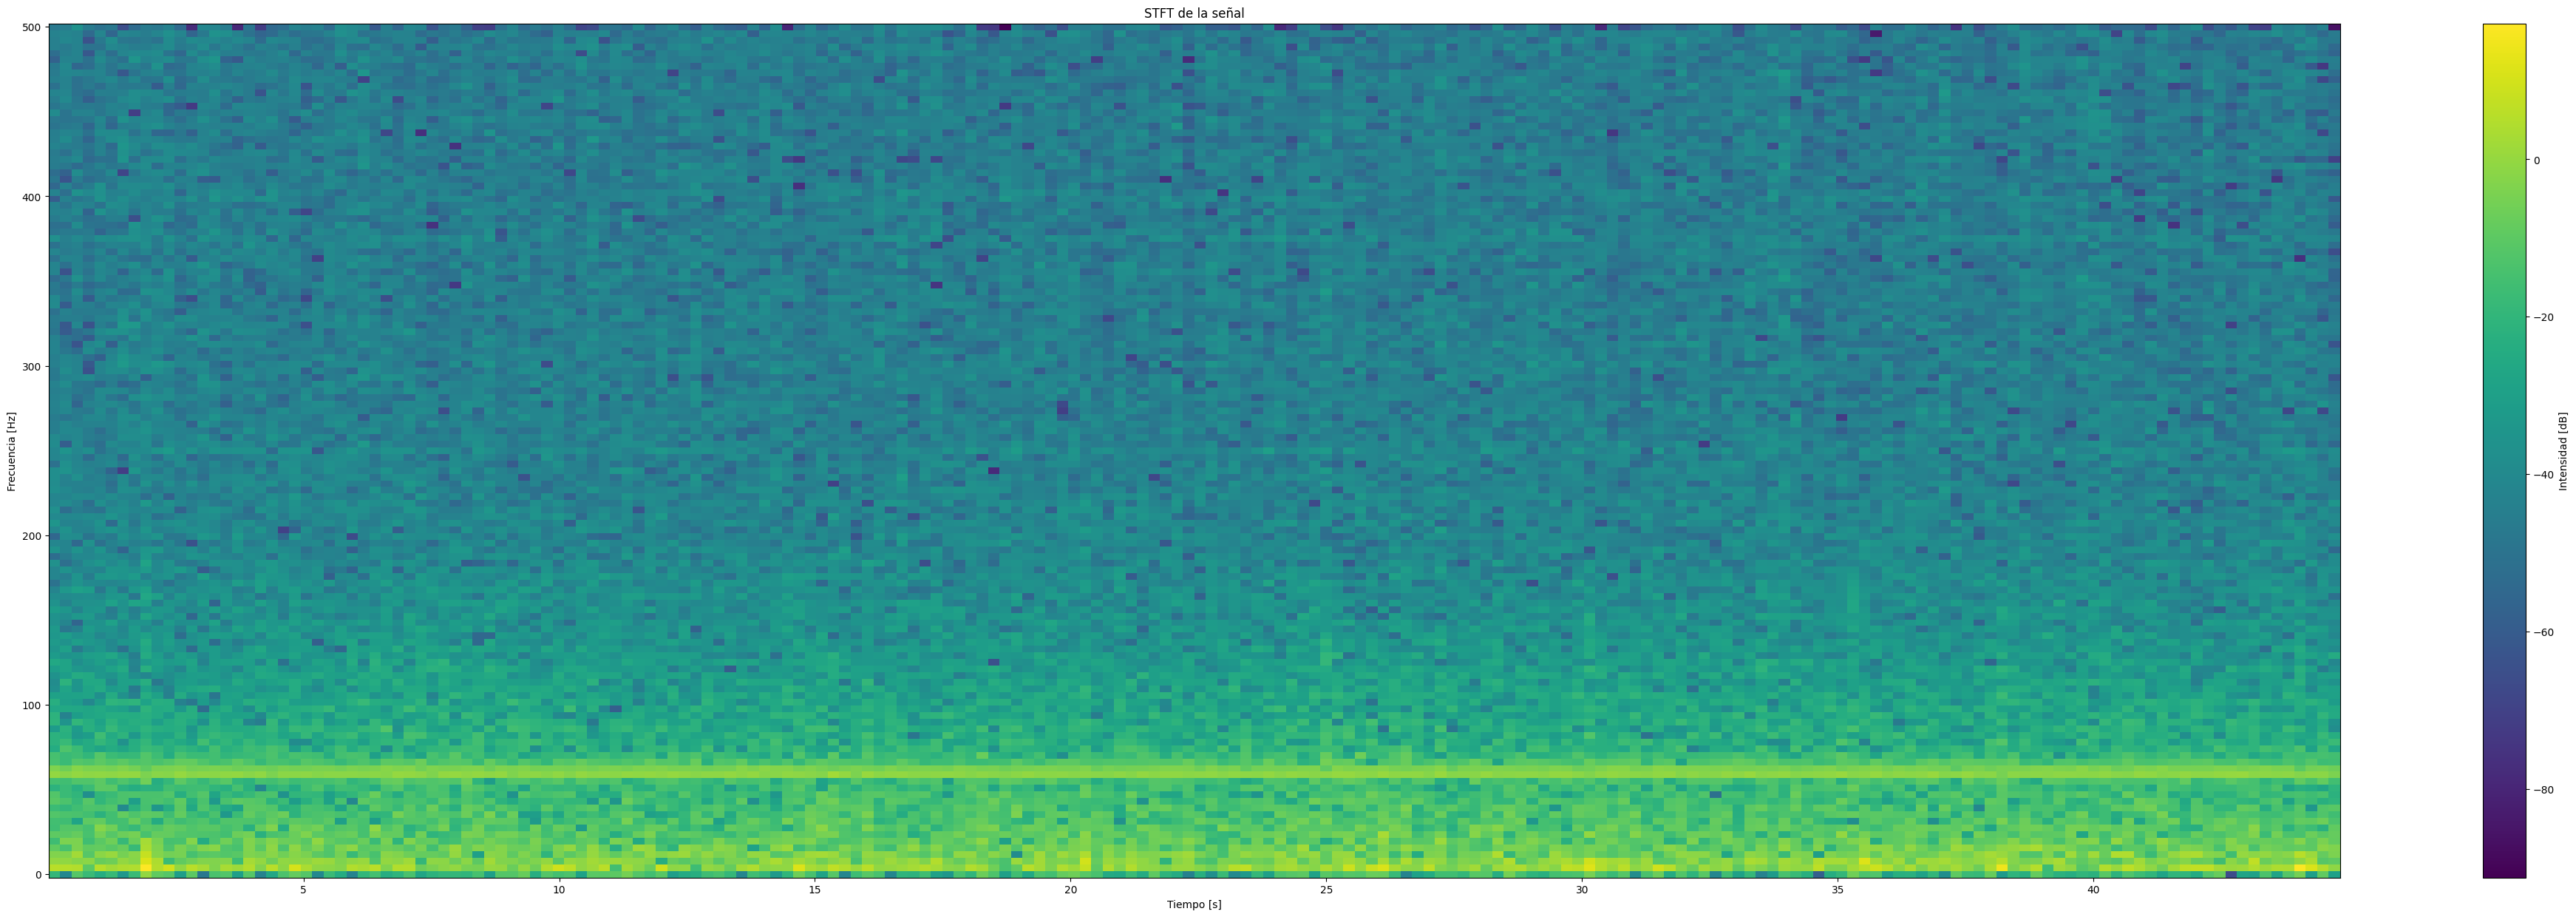

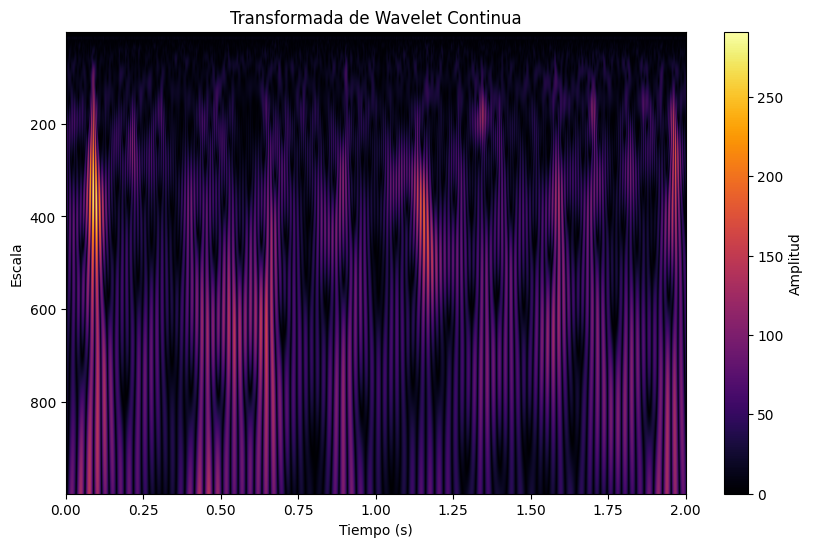

¿coinciden frecuencias?  True


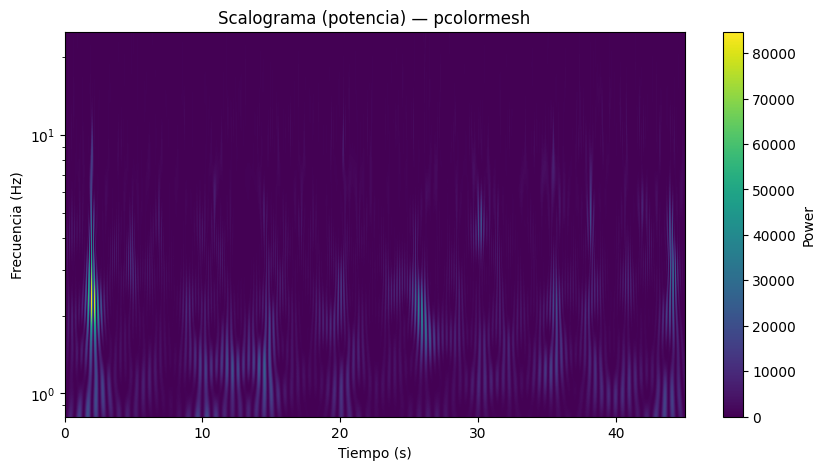

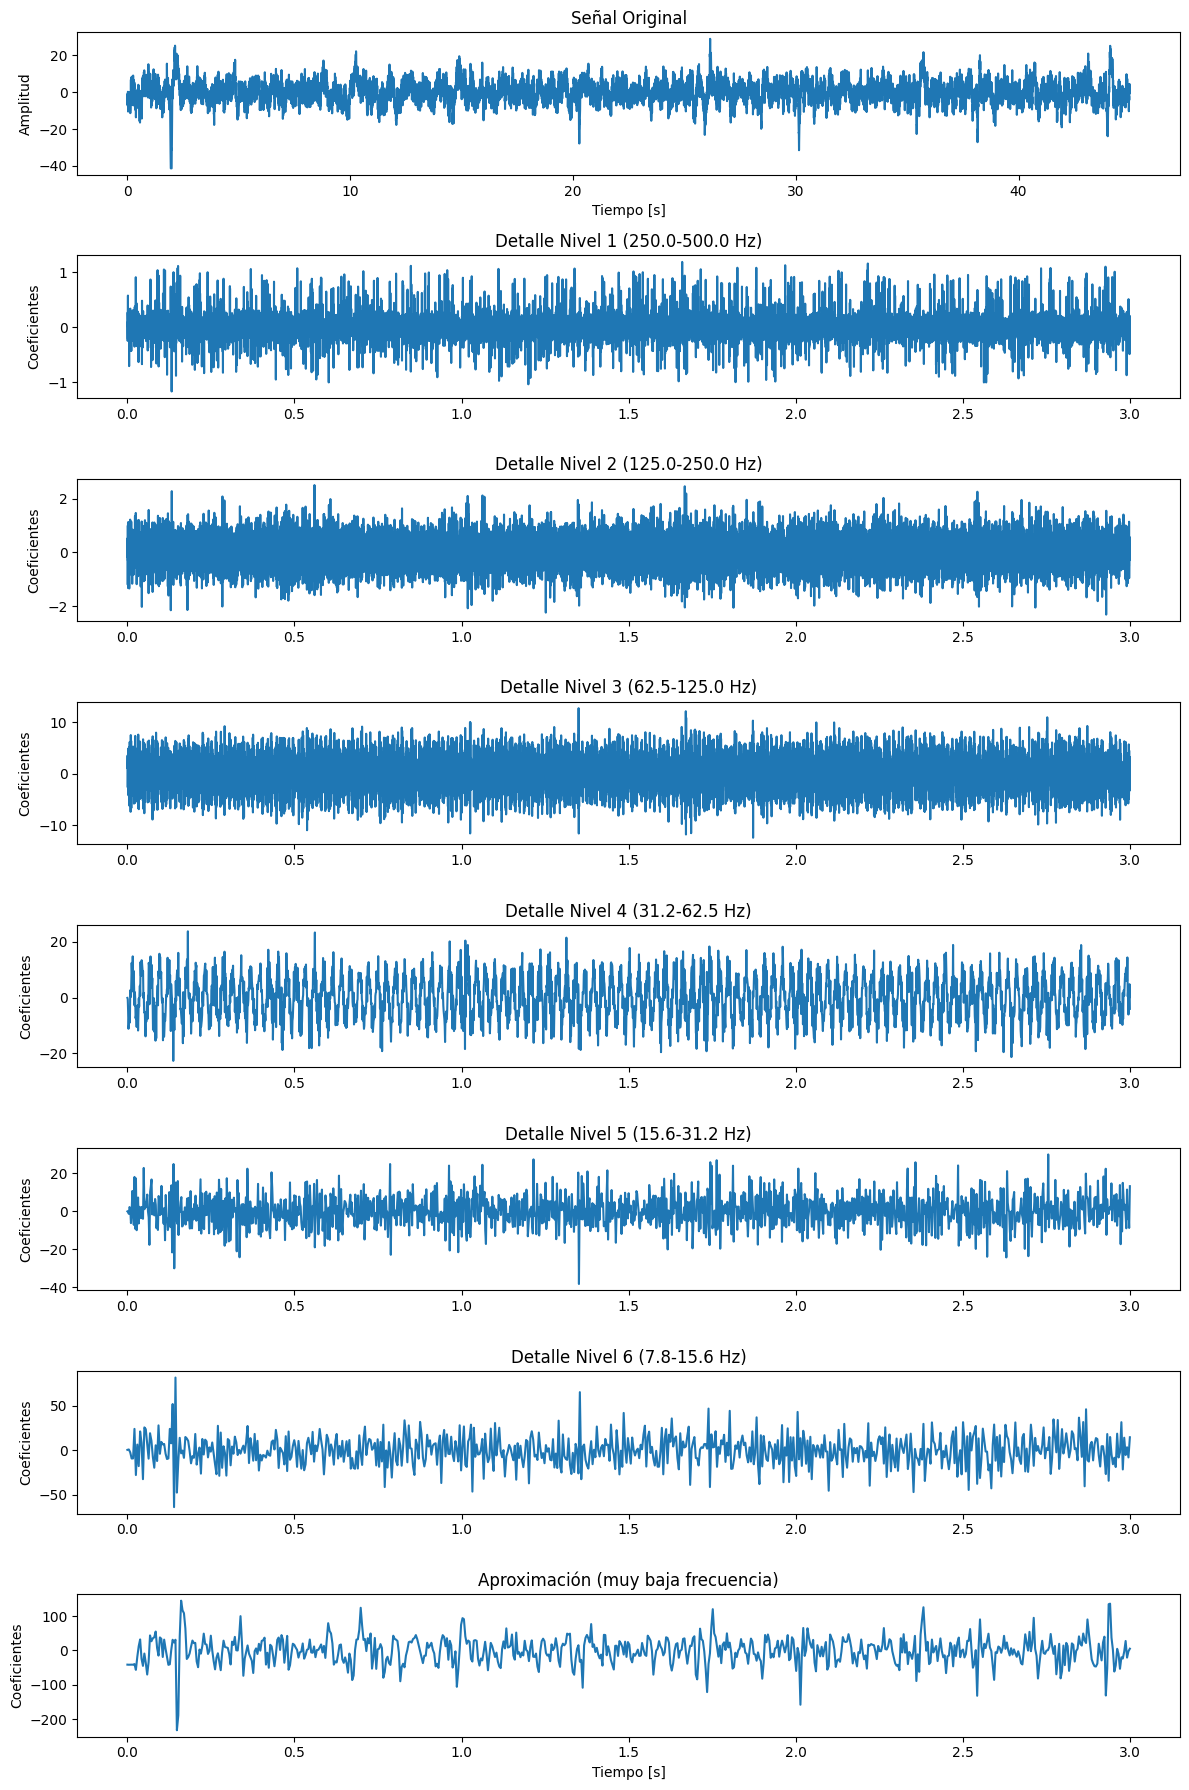

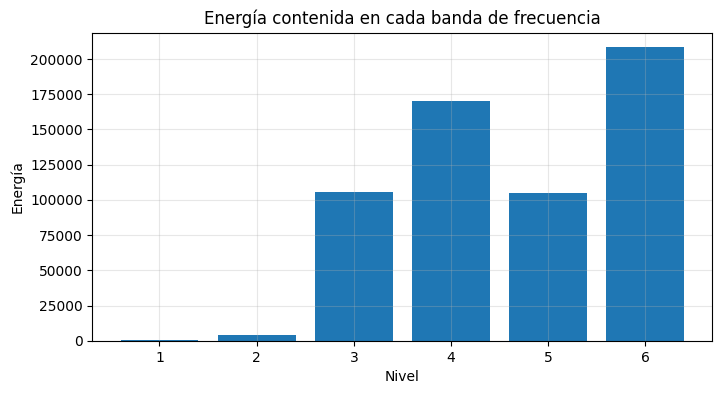

Nivel 1: 250.00 - 500.00 Hz | Energía = 705.30
Nivel 2: 125.00 - 250.00 Hz | Energía = 4261.61
Nivel 3: 62.50 - 125.00 Hz | Energía = 105547.47
Nivel 4: 31.25 - 62.50 Hz | Energía = 169902.25
Nivel 5: 15.62 - 31.25 Hz | Energía = 105038.06
Nivel 6: 7.81 - 15.62 Hz | Energía = 208239.28


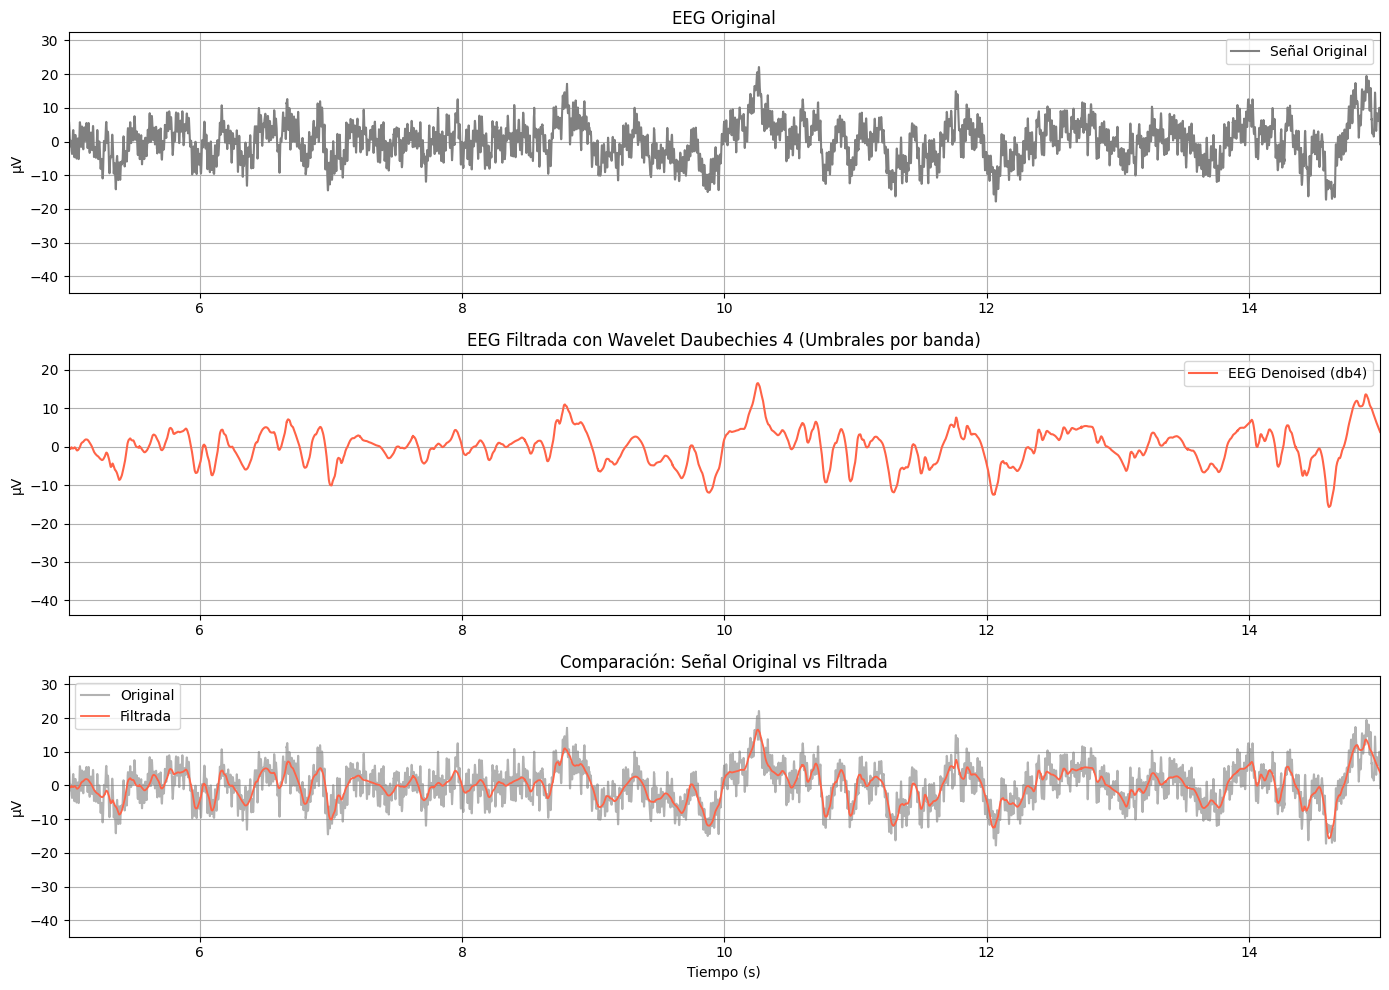

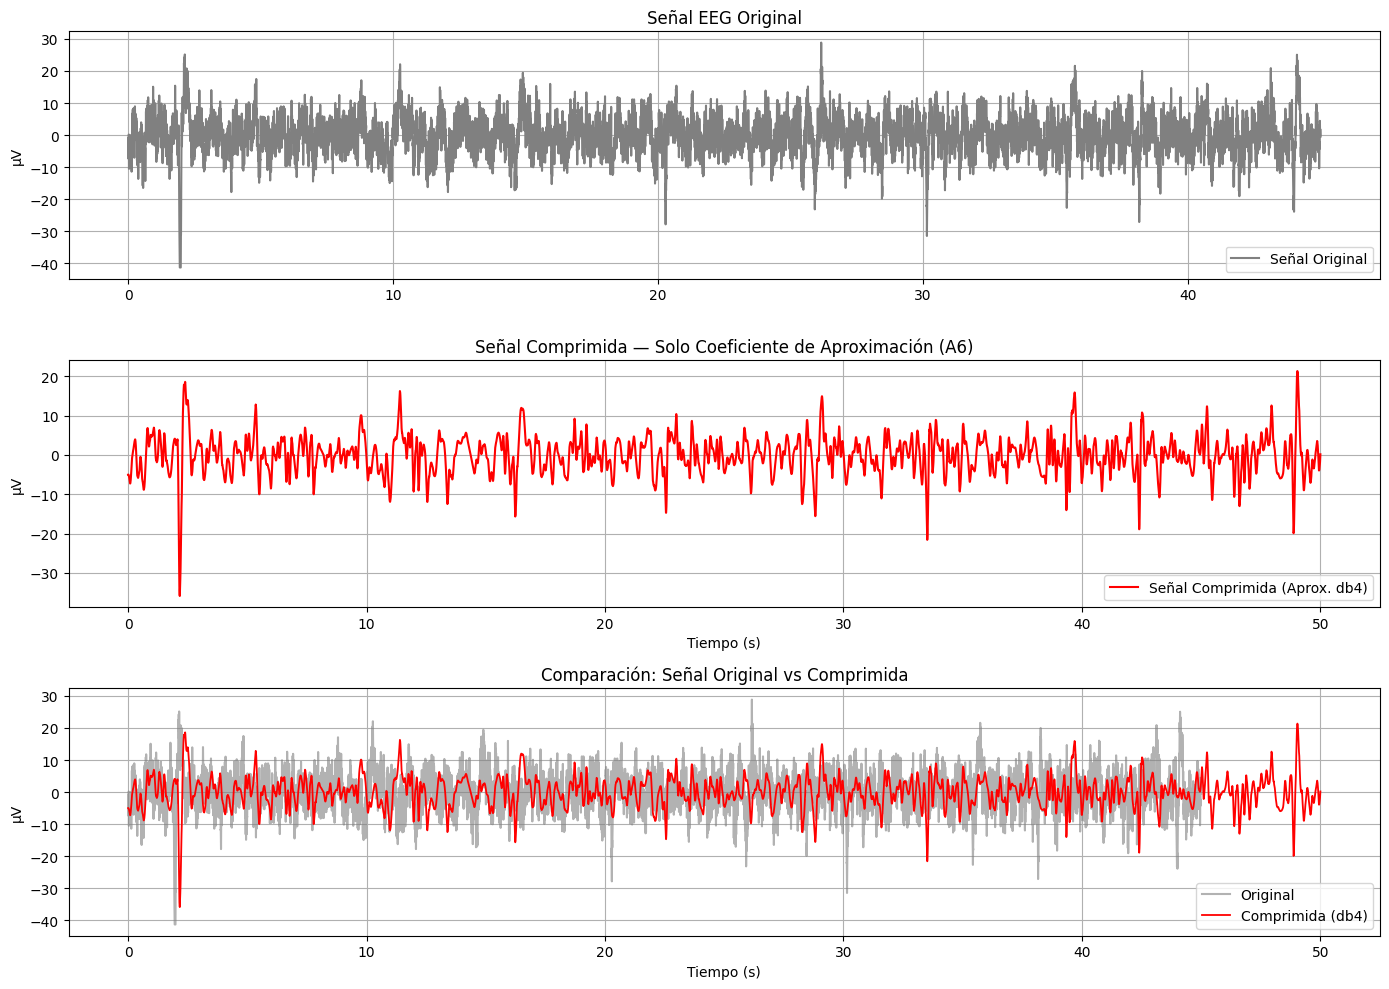

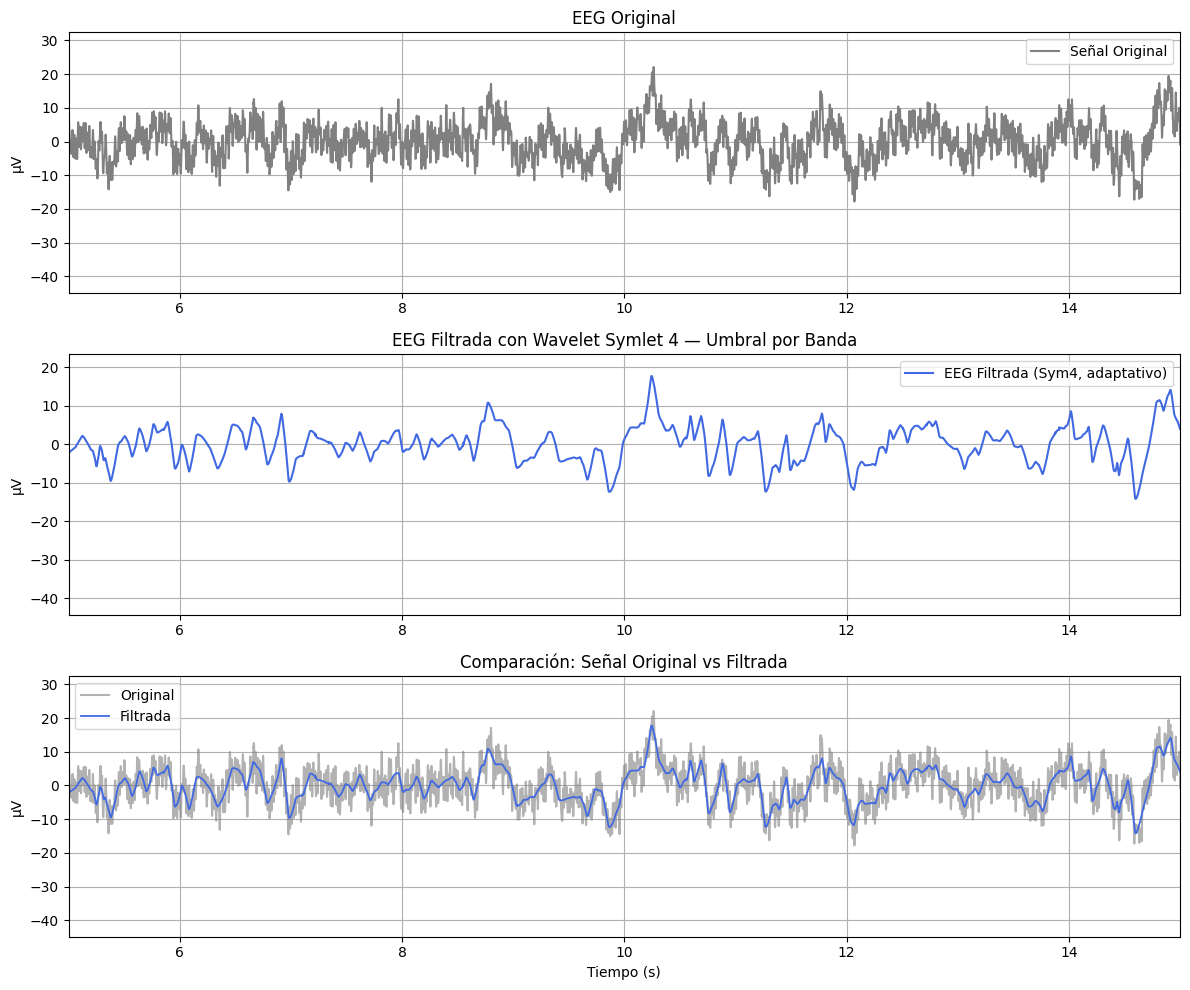

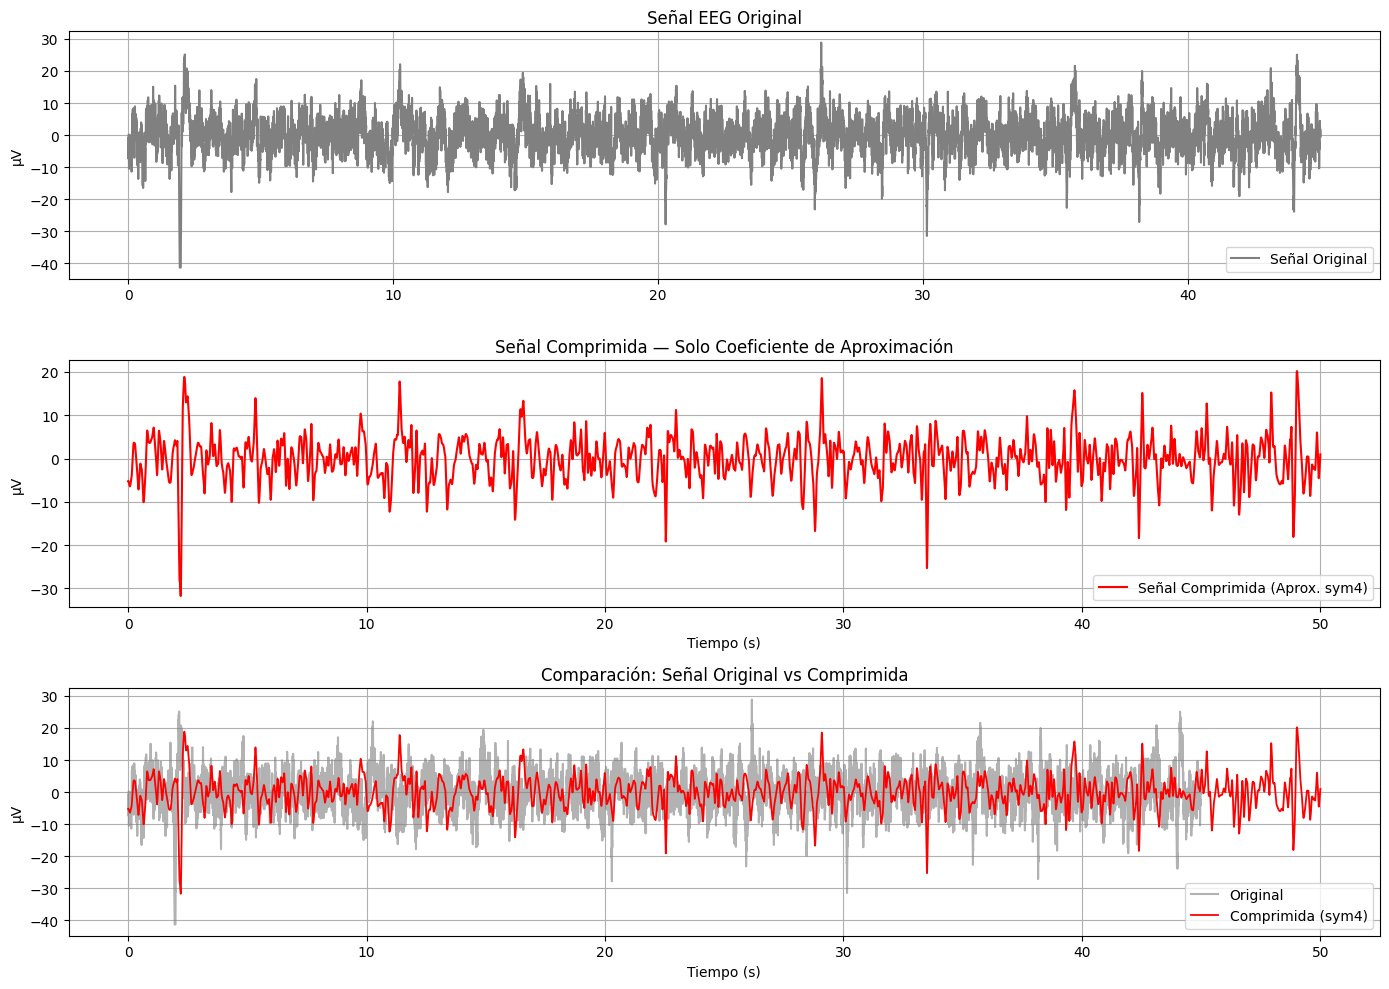

In [29]:
# --- Gráfico de la señal EEG ---
plt.figure(figsize=(12, 5))
plt.plot(t_3, y_3, label="Señal EEG")
plt.title("Tarea cognitiva", fontsize=14, fontweight='bold', loc='center')  # centrado correctamente
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud (µV)")
plt.grid(linestyle=":")
plt.legend()
plt.tight_layout()
plt.show()

## DFT
X = np.fft.fft(y_3)
frequencies = np.fft.fftfreq(len(y_3), 1/fs)

plt.subplot(2, 1, 2)
plt.plot(frequencies, np.abs(X))
plt.title('Espectro de frecuencias')
plt.xlabel('Frecuencia [Hz]')
plt.grid()
plt.xlim([-100, 100])
plt.tight_layout()
plt.show()

## STFT
f, t, Sxx = spectrogram(y_3, fs)
plt.figure(figsize=(50, 15))
plt.pcolormesh(t, f, 10 * np.log10(Sxx))
plt.title('STFT de la señal')
plt.ylabel('Frecuencia [Hz]')
plt.xlabel('Tiempo [s]')
plt.colorbar(label='Intensidad [dB]')
plt.show()

# Transformada de Wavelet Continua (CWT)
escala = np.arange(1, 1000)
coeficientes, frecuencias = pywt.cwt(y_3, escala, 'morl',sampling_period=1/1000)
plt.figure(figsize=(10, 6))
plt.imshow(np.abs(coeficientes), extent=[0, 2, escala[-1], escala[0]], aspect='auto', cmap='inferno')
plt.colorbar(label='Amplitud')
plt.title('Transformada de Wavelet Continua')
plt.xlabel('Tiempo (s)')
plt.ylabel('Escala')
plt.show()

freqs_check = pywt.scale2frequency('morl', escala) * fs
print("¿coinciden frecuencias? ", np.allclose(frecuencias, freqs_check))
power = np.abs(coeficientes)**2
power_norm = power / np.sqrt(escala)[:, None]
plt.figure(figsize=(10,5))
plt.pcolormesh(t_3, frecuencias, power, shading='auto');
plt.ylabel('Frecuencia (Hz)')
plt.xlabel('Tiempo (s)')
plt.yscale('log')
plt.title('Scalograma (potencia) — pcolormesh')
plt.colorbar(label='Power')
plt.ylim(frecuencias.min(),25)
plt.show()


# Transformada de Wavelet Discreta (DWT)

wavelet = 'db4'
niveles = 6
coeficientes = pywt.wavedec(y_3, wavelet, level=niveles)
detalles = coeficientes[1:][::-1]
energias = [np.sum(np.square(c)) for c in detalles]
bandas = [(fs / (2 ** (i + 1)), fs / (2 ** i)) for i in range(1, niveles + 1)]
plt.figure(figsize=(12, 18))
plt.subplot(niveles + 2, 1, 1)
plt.plot(t_3, y_3)
plt.title('Señal Original')
plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud')

# Graficar los niveles 1 → n (altas → bajas)
for i, c in enumerate(detalles, start=1):
    t_c = np.linspace(0, 3, len(c))  # eje temporal aproximado
    plt.subplot(niveles + 2, 1, i + 1)
    plt.plot(t_c, c)
    plt.title(f'Detalle Nivel {i} ({bandas[i-1][0]:.1f}-{bandas[i-1][1]:.1f} Hz)')
    plt.ylabel('Coeficientes')

# Aproximación final
t_a = np.linspace(0, 3, len(coeficientes[0]))
plt.subplot(niveles + 2, 1, niveles + 2)
plt.plot(t_a, coeficientes[0])
plt.title('Aproximación (muy baja frecuencia)')
plt.xlabel('Tiempo [s]')
plt.ylabel('Coeficientes')
plt.tight_layout()
plt.show()

#Energía por nivel
plt.figure(figsize=(8, 4))
niveles_list = np.arange(1, niveles + 1)
plt.bar(niveles_list, energias)
plt.xlabel('Nivel')
plt.ylabel('Energía')
plt.title('Energía contenida en cada banda de frecuencia')
plt.xticks(niveles_list)
plt.grid(True, alpha=0.3)
plt.show()

# Tabla resumen
for i, (f_low, f_high) in enumerate(bandas):
    print(f"Nivel {i+1}: {f_low:.2f} - {f_high:.2f} Hz | Energía = {energias[i]:.2f}")


## Filtrar señal con Wavelet (db4)
# --- Descomposición wavelet ---
wavelet = 'db4'
nivel = 6
coeffs = pywt.wavedec(y_3, wavelet, level=nivel)

# --- Parámetros generales ---
fs = 1000  # Hz (frecuencia de muestreo)

# --- Aplicar umbrales manuales según banda EEG ---
coeffs_umbral = []
for i, c in enumerate(coeffs):
    if i == 0:
        # A6 → componente más lenta (delta + theta)
        # No se filtra agresivamente
        coeffs_umbral.append(c)
    else:
        # Estimación del ruido y umbral tipo VisuShrink
        sigma = np.median(np.abs(c)) / 0.6745
        T = sigma * np.sqrt(2 * np.log(len(c)))

        # Nota: i=1 → D6, i=6 → D1 (orden inverso en PyWavelets)
        if i == 1:  # D6 (alfa, 8–16 Hz)
            T *= 0.3  # conservar más señal
        elif i == 2:  # D5 (beta, 16–32 Hz)
            T *= 0.6
        elif i == 3:  # D4 (gamma baja)
            T *= 0.8
        elif i == 4:  # D3 (gamma alta)
            T *= 1
        elif i >= 5:  # D2-D1 (ruido)
            T *= 1.5  # filtrar más agresivo

        # Aplicar umbral suave
        coeffs_umbral.append(pywt.threshold(c, T, mode='soft'))

# --- Reconstrucción denoised ---
senal_denoised = pywt.waverec(coeffs_umbral, wavelet)
senal_denoised = senal_denoised[:len(y_3)]  # ajustar tamaño si varía

# --- Asignar bandas EEG aproximadas ---
bandas = ['A6 (δ+θ 0–8 Hz)', 'D6 (α 8–16 Hz)', 'D5 (β 16–32 Hz)',
          'D4 (γ baja 32–64 Hz)', 'D3 (γ alta 64–128 Hz)',
          'D2 (ruido muscular 128–256 Hz)', 'D1 (ruido >256 Hz)']

# --- Gráficas comparativas ---
plt.figure(figsize=(14, 10))

# Señal original
plt.subplot(3, 1, 1)
plt.plot(t_3, y_3, color='gray', label='Señal Original')
plt.title('EEG Original')
plt.xlim(5, 15)
plt.ylabel('µV')
plt.grid(True)
plt.legend()

# Señal denoised
plt.subplot(3, 1, 2)
plt.plot(t_3, senal_denoised, color='tomato', label='EEG Denoised (db4)')
plt.title('EEG Filtrada con Wavelet Daubechies 4 (Umbrales por banda)')
plt.xlim(5, 15)
plt.ylabel('µV')
plt.grid(True)
plt.legend()

# Comparación directa
plt.subplot(3, 1, 3)
plt.plot(t_3, y_3, color='gray', alpha=0.6, label='Original')
plt.plot(t_3, senal_denoised, color='tomato', linewidth=1.3, label='Filtrada')
plt.title('Comparación: Señal Original vs Filtrada')
plt.xlim(5, 15)
plt.xlabel('Tiempo (s)')
plt.ylabel('µV')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


# --- Compresión usando solo el coeficiente de aproximación (A6) ---
coef_aproximacion = coeffs_umbral[0]
coeffs_zero = [np.zeros_like(c) for c in coeffs]
coeffs_zero[0] = coef_aproximacion
senal_comprimida = pywt.waverec(coeffs_zero, wavelet)
t_3_2 = np.linspace(0, len(y_2)/fs, len(senal_comprimida))  # tiempo

# --- Gráficas de compresión ---
plt.figure(figsize=(14, 10))

# 1. Señal original
plt.subplot(3, 1, 1)
plt.plot(t_3, y_3, label='Señal Original', color='gray')
plt.title('Señal EEG Original')
plt.ylabel('µV')
plt.grid(True)
plt.legend()

# 2️. Señal comprimida
plt.subplot(3, 1, 2)
plt.plot(t_3_2, senal_comprimida, label='Señal Comprimida (Aprox. db4)', color='red')
plt.title('Señal Comprimida — Solo Coeficiente de Aproximación (A6)')
plt.ylabel('µV')
plt.xlabel('Tiempo (s)')
plt.grid(True)
plt.legend()

# 3️. Comparación directa (superposición)
plt.subplot(3, 1, 3)
plt.plot(t_3, y_3, color='gray', alpha=0.6, label='Original')
plt.plot(t_3_2, senal_comprimida, color='red', linewidth=1.3, label='Comprimida (db4)')
plt.title('Comparación: Señal Original vs Comprimida')
plt.xlabel('Tiempo (s)')
plt.ylabel('µV')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


## Filtrar señal con Wavelet (sym4)
# --- Descomposición en wavelets ---
wavelet = 'sym4'
nivel = 6
coeffs = pywt.wavedec(y_3, wavelet, level=nivel)

# --- Frecuencia de muestreo ---
fs = 1000  # Hz

# --- Bandas EEG aproximadas según nivel (para fs = 1000 Hz y nivel=6) ---
bandas = {
    6: "A6 (0–8 Hz) δ+θ",
    5: "D6 (8–16 Hz) α",
    4: "D5 (16–32 Hz) β",
    3: "D4 (32–64 Hz) γ baja",
    2: "D3 (64–128 Hz) γ alta",
    1: "D2 (128–256 Hz) ruido",
    0: "D1 (>256 Hz) ruido eléctrico"
}

# --- Cálculo de umbral adaptativo por nivel ---
coeffs_umbral = []
for i, c in enumerate(coeffs):
    if i == 0:
        # A6 → componente más lenta (delta + theta)
        # No se filtra agresivamente
        coeffs_umbral.append(c)
    else:
        # Estimación del ruido y umbral tipo VisuShrink
        sigma = np.median(np.abs(c)) / 0.6745
        T = sigma * np.sqrt(2 * np.log(len(c)))

        # Ajustar el umbral por nivel (menor en bandas cerebrales, mayor en ruido)
        # Nota: i=1 → D6, i=6 → D1 (orden inverso en PyWavelets)
        if i == 1:  # D6 (alfa, 8–16 Hz)
            T *= 0.3  # conservar más señal
        elif i == 2:  # D5 (beta, 16–32 Hz)
            T *= 0.6
        elif i == 3:  # D4 (gamma baja)
            T *= 0.8
        elif i == 4:  # D3 (gamma alta)
            T *= 1
        elif i >= 5:  # D2-D1 (ruido)
            T *= 1.5  # filtrar más agresivo

        # Aplicar umbral suave
        coeffs_umbral.append(pywt.threshold(c, T, mode='soft'))

# --- Reconstrucción de la señal filtrada ---
senal_denoised = pywt.waverec(coeffs_umbral, wavelet)

# --- Gráficas ---
plt.figure(figsize=(12, 10))

# 1️ Señal original
plt.subplot(3, 1, 1)
plt.plot(t_3, y_3, color='gray', label='Señal Original')
plt.title('EEG Original')
plt.xlim(5, 15)
plt.ylabel('µV')
plt.grid(True)
plt.legend()

# 2️ Señal filtrada
plt.subplot(3, 1, 2)
plt.plot(t_3, senal_denoised, color='royalblue', label='EEG Filtrada (Sym4, adaptativo)')
plt.title('EEG Filtrada con Wavelet Symlet 4 — Umbral por Banda')
plt.xlim(5, 15)
plt.ylabel('µV')
plt.grid(True)
plt.legend()

# 3️ Comparación directa
plt.subplot(3, 1, 3)
plt.plot(t_3, y_3, color='gray', alpha=0.6, label='Original')
plt.plot(t_3, senal_denoised, color='royalblue', linewidth=1.3, label='Filtrada')
plt.title('Comparación: Señal Original vs Filtrada')
plt.xlim(5, 15)
plt.xlabel('Tiempo (s)')
plt.ylabel('µV')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


coef_aproximacion = coeffs_umbral[0]
coeffs_zero = [np.zeros_like(c) for c in coeffs]
coeffs_zero[0] = coef_aproximacion
senal_comprimida = pywt.waverec(coeffs_zero, 'sym4')
t_3_2 = np.linspace(0, len(y_2)/1000, len(senal_comprimida))  # Suponiendo que la frecuencia de muestreo es 1000 Hz


# --- Graficar ---
plt.figure(figsize=(14, 10))

# 1. Señal original
plt.subplot(3, 1, 1)
plt.plot(t_3, y_3, label='Señal Original', color='gray')
plt.title('Señal EEG Original')
plt.ylabel('µV')
plt.grid(True)
plt.legend()

# 2️. Señal comprimida
plt.subplot(3, 1, 2)
plt.plot(t_3_2, senal_comprimida, label='Señal Comprimida (Aprox. sym4)', color='red')
plt.title('Señal Comprimida — Solo Coeficiente de Aproximación')
plt.ylabel('µV')
plt.xlabel('Tiempo (s)')
plt.grid(True)
plt.legend()

# 3️. Comparación directa (superposición)
plt.subplot(3, 1, 3)
plt.plot(t_3, y_3, color='gray', alpha=0.6, label='Original')
plt.plot(t_3_2, senal_comprimida, color='red', linewidth=1.3, label='Comprimida (sym4)')
plt.title('Comparación: Señal Original vs Comprimida')
plt.xlabel('Tiempo (s)')
plt.ylabel('µV')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
